# Final Exercise: Loan Propensity Model

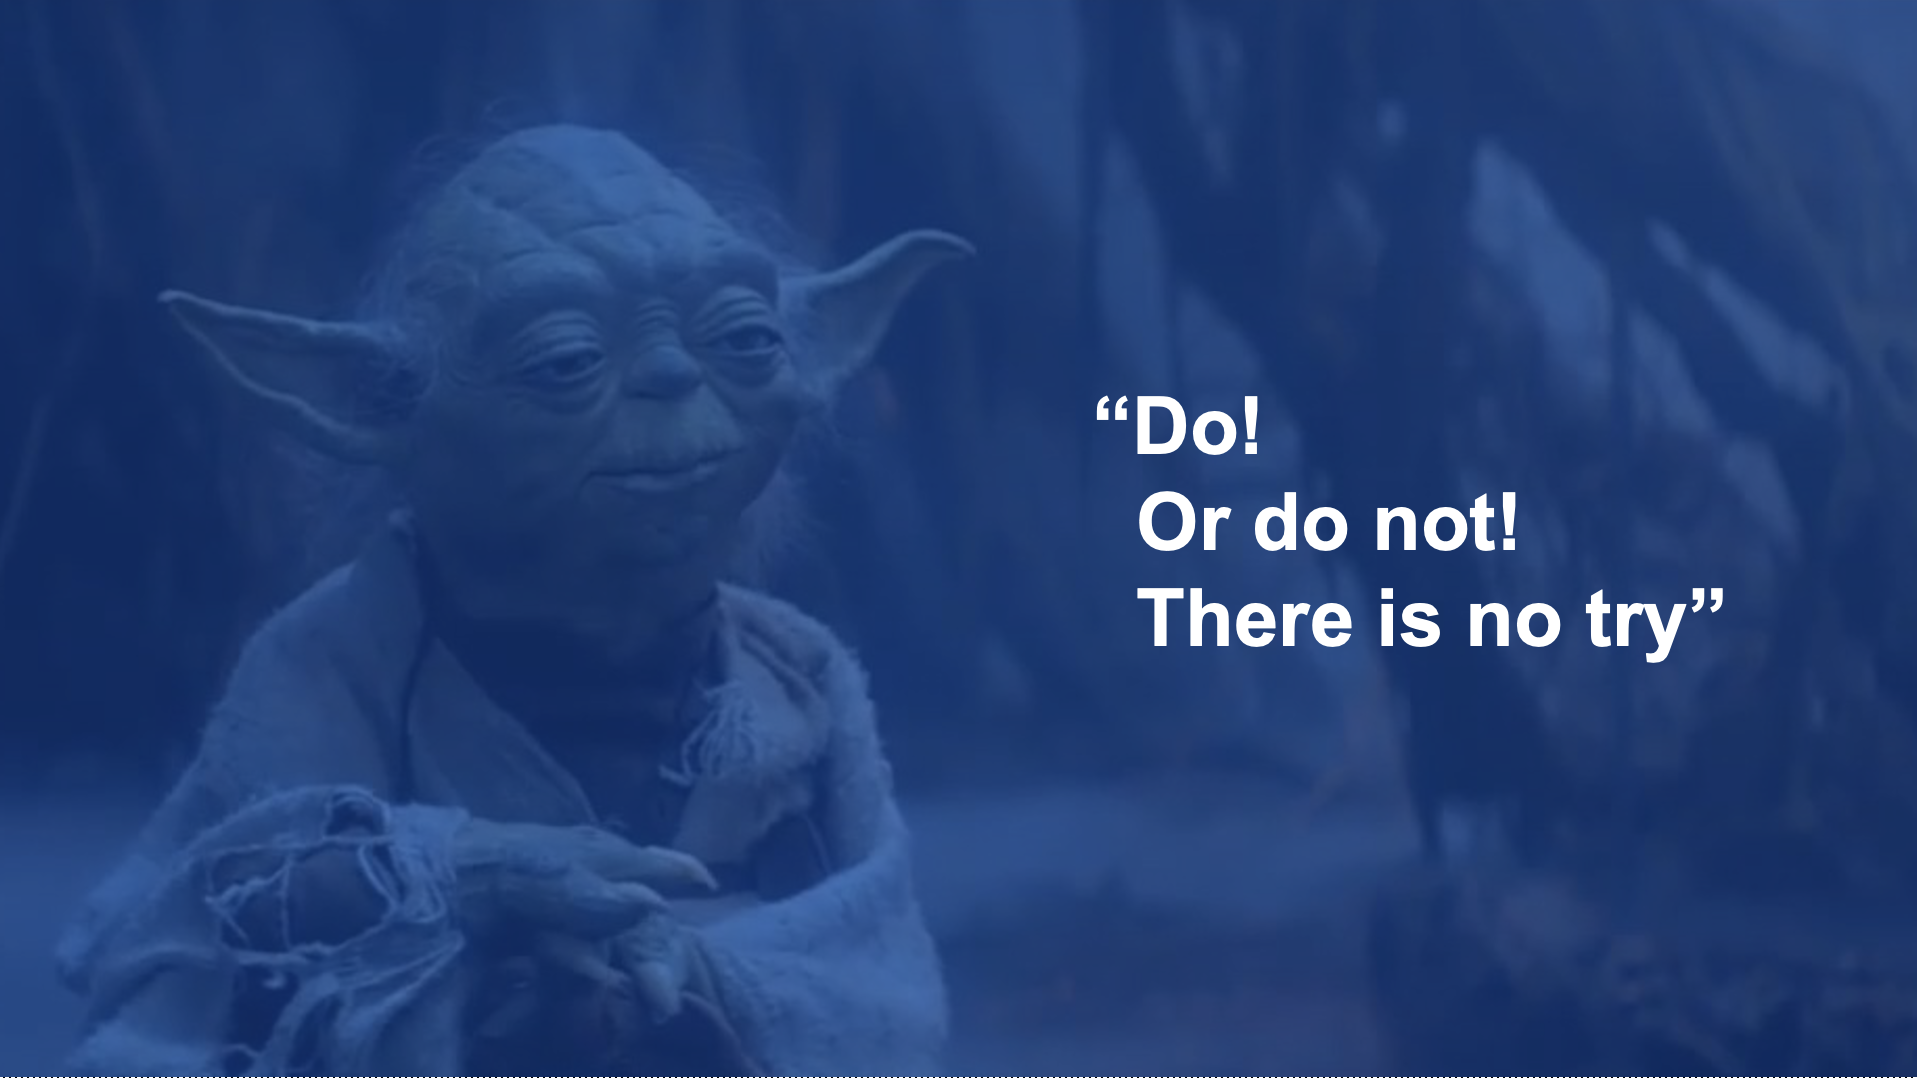

#### Goal:
<mark>*Build a classification model able to predict how likely a customer is about to request a loan.*</mark>

#### Tasks:

1. Build a single customer view with all available information that could be useful to solve the classification task
    - Do not include any information that was not available before the loan request
        - Filter the credit card table to keep only those credit card issued before the loan date
        - Filter the transaction table to keep only transactions occurred before the loan date
        - Customers who don't have any loan will have `NaT` as `loan date`. In order to properly filter both the credit card table and the transaction table you will have to fill `NaT` values in `loan date` with a date "*far in the future*" with respect to the time range of the dataset. To correctly choose the "*date far in future*" please be aware of this [**open issue in pandas datetime**](https://github.com/pandas-dev/pandas/issues/28104)
    - The data preparation pipeline is already implemented in this notebook except the two blocks where you have to implement the proper filter for the credit card and transaction table. If you will keep the naming convention consistant no other modification are required.


2. Build a classification model to predict whether a customer is about to request a loan 
    - Build the proper data preprocessing pipeline
     <img src="./pics/titanic_workflow.png" alt="Drawing" style="width: 600px;"/>
    - Split data into training and test set
    - Check if the target variable is balanced or unbalanced 
        - how many accounts have target 0?
        - how many have target 1?
        - how can we rebalance to a 50%-50% ratio between target 0 and target 1?
    - While bilding the classification model be aware that some variables (e.g. `account_life_days`) are biased twords the target due to the fact that we artificially cut-off the transaction timeseries ***only*** for custumers with a loan and not for those without.
        - Try to train a simple logistic regression model including those variables and verify that:
            - The model will have a performance definitely too high
            - The variables with a bias towards the target will have a feature importance much higher than anything else
        - Remove those variables train a logistic regression:
            1. without rebalancing the dataset
            2. rebalancing the dataset (how would you rebalance? undersampling? oversampling? both? cost sensitive learning using the `class_weight='balanced'` option?
            3. What is the impact of rebalancing on the probability distribution of the minority class? 
     - Optimize hyperparameters and train a Decision Tree model and a Random Forest model
         - Which is the most performing model?
         - Which are the most important features?        

#### Perimeter & Assumptions:
- Consider only accounts without any "DISPONENT" associeted to it
- The table "order" doesn't contain any timespamp. Even if the timestamp could be reconstructed from the transactions, for the porpouse of this exercise you can consider every order as a valid one removing (obviously) those orders related to loans

## Data Preparation: Building the Single Customer View

***Goal:*** By leveraging all available information in the dataset build a unified customer view including as many information about the customer financial behaviour as possible.

![](./pics/data_ERmap_simplified.gif)

*data documentation: https://web.archive.org/web/20161019192412/http://lisp.vse.cz/pkdd99/berka.htm

**<mark>Task 0:</mark>** Brainstorming session - Identify which information could be useful to describe the financial behaviour of a customer. (hint: features can be also computed from available information)

<center>
<img src="pics/data_ERmap_simplified_fields.png" alt="Drawing" style="width: 1100px; height: 600px"/>
</center>

- data prep: https://github.com/justinng1/berka

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix

import os
import itertools
import warnings

import seaborn as sns
from scipy.stats import ks_2samp

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
warnings.filterwarnings('ignore')
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
pd.options.display.max_columns = 999

In [4]:
DATAFOLD = '../../Day2/new_banking_datasets/'

#DATAFOLD = 'new_banking_datasets/'

df = {}

for f_name in os.listdir(DATAFOLD):
    if f_name[-4:]=='.csv' and f_name not in ['online-retail-dataset.csv','trans_old.csv','titanic3.csv']:
        print(f_name)
        df[f_name[:-4]] = pd.read_csv('{0}{1}'.format(DATAFOLD,f_name), sep=',',header=0)

trans.csv
order.csv
card.csv
account.csv
disp.csv
loan.csv
client.csv


In [5]:
for n_df in sorted(df):
    print('\n'+n_df)
    df[n_df].info(verbose = True)
    print('\n---------------------------\n')
    print(df[n_df].head(2))
    print('\n---------------------------\n\n')


account
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   account_id           4500 non-null   int64 
 1   district_id          4500 non-null   int64 
 2   account_frequency    4500 non-null   object
 3   account_date         4500 non-null   object
 4   account_date_opened  4500 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 175.9+ KB

---------------------------

   account_id  district_id account_frequency account_date  account_date_opened
0         576           55           MONTHLY   1993-01-01                    0
1        3818           74           MONTHLY   1993-01-01                    0

---------------------------



card
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            -------------

# Optimising the memory footprint
Let's save some memory by:
- Set all dates as type datetime
- IDs are imported sometime as int sometime as float, converting them to string
- Set the type of categorical variables as **category** to enable hashing
- Decrise the procision of **int** and **float**, from 64bits to 32bits

In [6]:
def CheckMemoryPrint(df):
    tmp = pd.DataFrame(data=[{n_df:df[n_df].memory_usage(deep=True).sum() for n_df in sorted(df)}])
    return tmp

In [7]:
old = CheckMemoryPrint(df)

In [8]:
print("Old memory footprint in bytes for each table:")
old


Old memory footprint in bytes for each table:


account    card  client    disp    loan    order       trans
0   697760  137979  483338  465338  118114  1049786  2741932574

In [9]:
for n_df in sorted(df):
    for col in df[n_df].columns:
        if col[-5:]=='_date' or col[-7:]=='_issued':
            df[n_df][col] = pd.to_datetime(df[n_df][col])
            
        elif col[-3:]=='_id':
            df[n_df][col] = df[n_df][col].astype('str').apply(lambda x: x.split('.')[0])
            
        elif df[n_df][col].dtype is np.dtype('object'):
            df[n_df][col] = df[n_df][col].astype('category')
            
        elif (df[n_df][col].dtype is np.dtype('int64') or df[n_df][col].dtype is np.dtype('float64')):
            df[n_df][col] = df[n_df][col].astype(str(df[n_df][col].dtype)[:-2]+'32')
            
        else:
            print(n_df,col,df[n_df][col].dtype)

In [10]:
new = CheckMemoryPrint(df)
print('Old tot (Byte): ',old.values.sum())
print('New tot (Byte): ',new.values.sum())

Old tot (Byte):  2744884889
New tot (Byte):  1590652623


In [11]:
print('Old:')
old.head(1)

Old:


account    card  client    disp    loan    order       trans
0   697760  137979  483338  465338  118114  1049786  2741932574

In [12]:
print('New:')
new.head(1)

New:


account    card  client    disp    loan   order       trans
0   597034  119800  691089  985601  100816  861330  1587296953

In [13]:
for n_df in sorted(df):
    print('\n'+n_df)
    df[n_df].info(verbose = True)
    print('\n---------------------------\n')
    print(df[n_df].head(2))
    print('\n---------------------------\n\n')


account
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   account_id           4500 non-null   object        
 1   district_id          4500 non-null   object        
 2   account_frequency    4500 non-null   category      
 3   account_date         4500 non-null   datetime64[ns]
 4   account_date_opened  4500 non-null   int32         
dtypes: category(1), datetime64[ns](1), int32(1), object(2)
memory usage: 127.7+ KB

---------------------------

  account_id district_id account_frequency account_date  account_date_opened
0        576          55           MONTHLY   1993-01-01                    0
1       3818          74           MONTHLY   1993-01-01                    0

---------------------------



card
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 5 columns):


## Selecting accounts whitout any DISPONENT
Customers are connected with an acount with two different roles:
1. ***OWNER***
2. ***DISPONENT***

Each account must have an ***OWNER***, while the presence of a ***DISPONENT*** is optional.

In [14]:
df['disp'].head(5)

disp_id client_id account_id  disp_type
0       1         1          1      OWNER
1       2         2          2      OWNER
2       3         3          2  DISPONENT
3       4         4          3      OWNER
4       5         5          3  DISPONENT

In [15]:
print("Number of entries in the data table:                 {}".format(df['disp'].shape[0]))
print("Number of distinct clients in the data table:        {}".format(df['disp']['client_id'].nunique()))
print("Number of distinct accounts in the data table:       {}".format(df['disp']['account_id'].nunique()))
print("Number of distinct account owners in the data table: {}\n".format(df['disp'][df['disp'].disp_type == 'OWNER']['account_id'].nunique()))
      

Number of entries in the data table:                 5369
Number of distinct clients in the data table:        5369
Number of distinct accounts in the data table:       4500
Number of distinct account owners in the data table: 4500



In [16]:
tmp = df['disp'].groupby('account_id',as_index=False)\
                .agg({'disp_id':'max',
                      'client_id':'max',
                      'disp_type':[('set',lambda x: ",".join(set(x))),
                                   ('n_types',lambda x: len(set(x)))]})

tmp.sample(5,random_state=5)

account_id disp_id client_id        disp_type        
                    max       max              set n_types
1367       2187    2648      2648  DISPONENT,OWNER       2
285        1165    1403      1403  DISPONENT,OWNER       2
4379        930    1120      1120            OWNER       1
3927        685     822       822            OWNER       1
2835       3579    4317      4317            OWNER       1

In [17]:
def to_flat_index(df):
    df.columns = ["{0}_{1}".format(col[0],col[1]) if col[1]!=''\
               else col[0] for col in df.columns.to_flat_index()]
    return df

In [18]:
to_flat_index(tmp).sample(5,random_state=5)

account_id disp_id_max client_id_max    disp_type_set  disp_type_n_types
1367       2187        2648          2648  DISPONENT,OWNER                  2
285        1165        1403          1403  DISPONENT,OWNER                  2
4379        930        1120          1120            OWNER                  1
3927        685         822           822            OWNER                  1
2835       3579        4317          4317            OWNER                  1

## Analysis perimeter definition


The presence of two customers able to run operation over the same account has to be separately treated with respect to the case where there is only one owner. Indeed the financial behaviour could be largely biased by the presence of two different person (eventually exhibiting different financial behaviour). Therefore, for simplicity, we restrict the analysis perimeter only to those accounts connected only with one customer in the role of account owner.

In [19]:
df['disp_only_owners'] = \
    df['disp']  .groupby('account_id',as_index=False)\
                .agg({'disp_id':'max',
                      'client_id':'max',
                      'disp_type':[('set',lambda x: ",".join(set(x))),
                                   ('n_types',lambda x: len(set(x)))]})
#flat multi-index
df['disp_only_owners'] = to_flat_index(df['disp_only_owners'])

#filtering only owners
df['disp_only_owners'] = df['disp_only_owners'][df['disp_only_owners']['disp_type_set']=='OWNER']  

df['disp_only_owners'].head(5)

account_id disp_id_max client_id_max disp_type_set  disp_type_n_types
0          1           1             1         OWNER                  1
1         10          13            13         OWNER                  1
2        100         121           121         OWNER                  1
3       1000        1204          1204         OWNER                  1
4      10001       11995         12303         OWNER                  1

In [20]:
#fixing cols naming convention
df['disp_only_owners'] = df['disp_only_owners'].drop('disp_type_n_types',axis=1)
df['disp_only_owners'].columns = ['account_id', 'disp_id', 'client_id', 'disp_type']
df['disp_only_owners'].head(5)

account_id disp_id client_id disp_type
0          1       1         1     OWNER
1         10      13        13     OWNER
2        100     121       121     OWNER
3       1000    1204      1204     OWNER
4      10001   11995     12303     OWNER

In [21]:
print('Total number of accounts: 4500 - ',
      'Number of accounts only with owner: {0}'.format(df['disp_only_owners'].count()))
df['disp_only_owners'].head(10)

Total number of accounts: 4500 -  Number of accounts only with owner: account_id    3631
disp_id       3631
client_id     3631
disp_type     3631
dtype: int64


account_id disp_id client_id disp_type
0          1       1         1     OWNER
1         10      13        13     OWNER
2        100     121       121     OWNER
3       1000    1204      1204     OWNER
4      10001   11995     12303     OWNER
5      10005   12000     12308     OWNER
6      10018   12016     12324     OWNER
7      10019   12017     12325     OWNER
8       1002    1206      1206     OWNER
9      10022   12020     12328     OWNER

## Generate the first slice of the SCV

Filter the ```client``` table to the correct perimeter and add the ```account_id``` and the 	```disp_id``` to it. This table will represent the fist slice of the SCV

In [22]:
df['SCV'] = pd.merge(df['disp_only_owners'],
                     df['client'], 
                     on=['client_id'],how="left")
df['SCV'].head(10)

account_id disp_id client_id disp_type  client_birth_number district_id  \
0          1       1         1     OWNER               706213          18   
1         10      13        13     OWNER               745529          54   
2        100     121       121     OWNER               786029          41   
3       1000    1204      1204     OWNER               746109          77   
4      10001   11995     12303     OWNER               745405          24   
5      10005   12000     12308     OWNER               781129          64   
6      10018   12016     12324     OWNER               780306           8   
7      10019   12017     12325     OWNER               641030           8   
8       1002    1206      1206     OWNER               570621          50   
9      10022   12020     12328     OWNER               445408           1   

   client_age client_gender  
0   29.071234             F  
1   25.610958             F  
2   21.189041             F  
3   25.161644             F  
4   25.758904             F  
5   21.104109             M  
6   21.838356             M  
7   35.194519             M  
8   42.558903             M  
9   55.769863             F

## Connecting loans to the SCV

In [23]:
df['loan'].head(5)

loan_id account_id  loan_date  loan_amount  loan_duration  \
0    5314       1787 1993-07-05        96396             12   
1    5316       1801 1993-07-11       165960             36   
2    6863       9188 1993-07-28       127080             60   
3    5325       1843 1993-08-03       105804             36   
4    7240      11013 1993-09-06       274740             60   

   loan_monthly_payment loan_status  loan_date_days  
0                8033.0           B             185  
1                4610.0           A             191  
2                2118.0           A             208  
3                2939.0           A             214  
4                4579.0           A             248

In [24]:
df['SCV'] = pd.merge(df['SCV'],
                     df['loan'].drop('loan_id', axis = 1),
                     on = ['account_id'],
                     how = "left")


<span style="color:red"><font size="5">
***LATER YOU WILL HAVE TO FILTER OTHER TABLES ACCORDING TO THE LOAN DATE 
(FOR ANY CUSTOMER WHO PURCHASED A LOAN). ADD HERE A BLOCK TO FILL MISSING 
VALUE IN THE ```loan_date``` WITH A DATE FAR IN THE FUTURE. DUE TO SOME KNOWN 
BUGS IN THE DATETIME TYPE OF NUMPY REMEMBER TO CHECK THAT THE DATE YOU ARE
USING TO FILL MISSING VALUE IS PROPERLY ENCODED INTO THE DATAFRAME***
</font> </span>.

In [25]:

#df['loan']['loan_date'].head(3)


df['SCV']['loan_date'].fillna(value=pd.to_datetime('24/07/2022'), inplace=True) 












In [26]:
#CHECK THAT NOW MISSING VALUE IN THE ```loan_date``` ARE CORRECTLY FILTERED
df['SCV'].head(5)

account_id disp_id client_id disp_type  client_birth_number district_id  \
0          1       1         1     OWNER               706213          18   
1         10      13        13     OWNER               745529          54   
2        100     121       121     OWNER               786029          41   
3       1000    1204      1204     OWNER               746109          77   
4      10001   11995     12303     OWNER               745405          24   

   client_age client_gender  loan_date  loan_amount  loan_duration  \
0   29.071234             F 2022-07-24          NaN            NaN   
1   25.610958             F 2022-07-24          NaN            NaN   
2   21.189041             F 2022-07-24          NaN            NaN   
3   25.161644             F 2022-07-24          NaN            NaN   
4   25.758904             F 1996-07-11      19044.0           36.0   

   loan_monthly_payment loan_status  loan_date_days  
0                   NaN         NaN             NaN  
1                   NaN         NaN             NaN  
2                   NaN         NaN             NaN  
3                   NaN         NaN             NaN  
4                 529.0           C          1287.0

## Connecting credit cards to the SCV

- *Filter card issued after the loan date*
- *Add card information to the SCV (remember to properly treat ```Null``` values in particular in the ```card_type``` field)*

In [27]:

#print(df['SCV'].shape[0])

df['card'] = pd.merge(df['card'],
                     df['SCV'].drop(columns=['client_birth_number', 'district_id', 'client_age', 'loan_amount', 	'loan_duration', 'loan_monthly_payment', 'loan_status', 'loan_date_days']),
                     on = ['disp_id'],
                     how = "inner")


print(df['card'].shape[0])

df['card'].head(10)



741


card_id disp_id card_type card_issued  card_issued_days account_id  \
0    1005    9285   classic  1993-11-07               310       7753   
1     104     588   classic  1994-01-19               383        489   
2     747    4915   classic  1994-02-05               400       4078   
3      70     439   classic  1994-02-08               403        361   
4     377    2429   classic  1994-03-03               426       1999   
5     721    4680    junior  1994-04-05               459       3883   
6     437    2762   classic  1994-06-01               516       2282   
7     188    1146   classic  1994-06-19               534        950   
8      13      87   classic  1994-06-29               544         73   
9     732    4763   classic  1994-07-21               566       3948   

  client_id disp_type client_gender  loan_date  
0      9593     OWNER             F 1994-03-11  
1       588     OWNER             F 2022-07-24  
2      4915     OWNER             M 2022-07-24  
3       439     OWNER             F 2022-07-24  
4      2429     OWNER             M 2022-07-24  
5      4680     OWNER             F 2022-07-24  
6      2762     OWNER             F 2022-07-24  
7      1146     OWNER             M 2022-07-24  
8        87     OWNER             F 2022-07-24  
9      4763     OWNER             F 2022-07-24

<span style="color:red"><font size="5">
***ADD HERE A BLOCK OF CODE TO FILTER OUT FROM THE CREDIT CARD TABLE 
ANY CREDIT CARD ISSUED AFTER THE LOAN DATE***
</font> </span>.

In [28]:
## ADD YOUR CODE HERE. SAVE THE FILTERED DATASET OF CREDIT CARD
## INTO: df['card_filt']
## Tips: credit card owned by customer in perimeter
##       and issued before the loan date are 637


df['card_filt']=df['card'][df['card']['card_issued']<df['card']['loan_date']]







In [29]:
print(df['card_filt'].shape)


#df['card_filt']=df['card_filt'].drop(columns=['account_id','client_gender','disp_type'])

(637, 10)


In [30]:
df['card_filt'].head(2)

card_id disp_id card_type card_issued  card_issued_days account_id  \
0    1005    9285   classic  1993-11-07               310       7753   
1     104     588   classic  1994-01-19               383        489   

  client_id disp_type client_gender  loan_date  
0      9593     OWNER             F 1994-03-11  
1       588     OWNER             F 2022-07-24

## Connecting credit cards to the SCV

3.3. *Add card information to the SCV (remember to properly treat ```Null``` values in particular in the ```card_type ``` field)* 


In [31]:
df['SCV'] = pd.merge(df['SCV'], 
                     df['card_filt'][['card_type','card_issued','card_issued_days','client_id']],
                     on = ['client_id'],
                     how = "left")

df['SCV']['card_type'] = df['SCV']['card_type'] .astype(str)\
                                                .apply(lambda x: x if x!='nan' else 'no_card')\
                                                .astype('category')

In [32]:
df['SCV'].sample(5,random_state=5)

account_id disp_id client_id disp_type  client_birth_number district_id  \
603        1611    1954      1954     OWNER               520728          69   
1437       2591    3127      3127     OWNER               205618           1   
2024       3303    3995      3995     OWNER               485815           1   
2099       3392    4101      4101     OWNER               705507           1   
3128        644     773       773     OWNER               351030           4   

      client_age client_gender  loan_date  loan_amount  loan_duration  \
603    47.460274             M 2022-07-24          NaN            NaN   
1437   79.591782             F 2022-07-24          NaN            NaN   
2024   51.413700             F 2022-07-24          NaN            NaN   
2099   29.673973             F 2022-07-24          NaN            NaN   
3128   64.216438             M 2022-07-24          NaN            NaN   

      loan_monthly_payment loan_status  loan_date_days card_type card_issued  \
603                    NaN         NaN             NaN   classic  1997-07-01   
1437                   NaN         NaN             NaN   no_card         NaT   
2024                   NaN         NaN             NaN   no_card         NaT   
2099                   NaN         NaN             NaN   no_card         NaT   
3128                   NaN         NaN             NaN   no_card         NaT   

      card_issued_days  
603             1642.0  
1437               NaN  
2024               NaN  
2099               NaN  
3128               NaN

## Recurrent payments

Lets first convert all the orders ammount in Euro.

In [33]:
df['order']['order_amount'] = df['order']['order_amount']*0.039
df['order'].head(6)

order_id account_id order_bank_to  order_account_to  order_amount  \
0    29401          1            YZ          87144583     95.627998   
1    29402          2            ST          89597016    131.535294   
2    29403          2            QR          13943797    283.373993   
3    29404          3            WX          83084338     44.264999   
4    29405          3            CD          24485939     12.753000   
5    29406          3            AB          59972357    138.020996   

      order_k_symbol  
0  HOUSEHOLD_PAYMENT  
1       LOAN_PAYMENT  
2  HOUSEHOLD_PAYMENT  
3  HOUSEHOLD_PAYMENT  
4            UNKNOWN  
5  INSURANCE_PAYMENT

In [34]:
df['order']['order_k_symbol'].value_counts()

HOUSEHOLD_PAYMENT    3502
UNKNOWN              1379
LOAN_PAYMENT          717
INSURANCE_PAYMENT     532
LEASING_PAYMENT       341
Name: order_k_symbol, dtype: int64

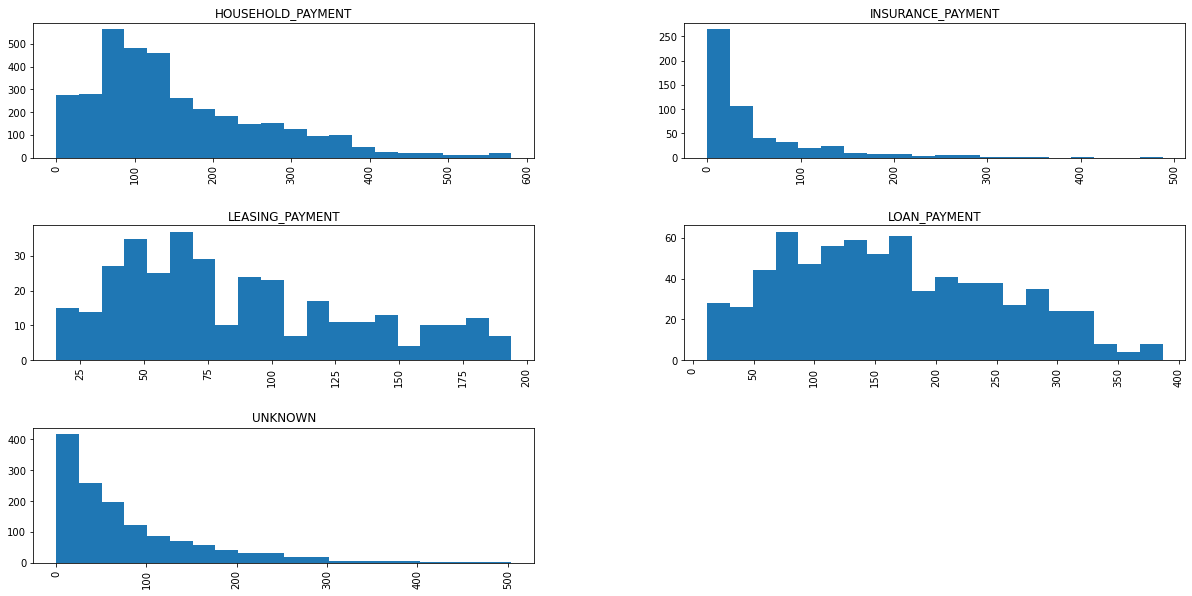

In [35]:
f = plt.figure(figsize=(20,10))
ax = f.add_subplot(111)
_ = df['order'].hist(column = 'order_amount', by = 'order_k_symbol', bins = 20, ax=ax)

**<mark>Task 4:</mark>**

1. *Aggregate the dataset by ```account_id``` in such a way that each distinct ```order_k_symbol``` becomes a column. The value associated to a specific column (i.e. ```INSURANCE_PAYMENT```) correspond to the sum of all orders of the same type for each account (i.e. the value of the column ```INSURANCE_PAYMENT``` corresponding to the ```account_id = x``` is the sum of all ```order_amount``` of the ```account_id = x``` corresponding to ```order_k_symbol = INSURANCE_PAYMENT```*

<center>
<img src="./pics/order_transf.png" alt="Drawing" align="middle" style="width: 600px;"/>
</center>

2. *Add the aggregated orders information to the SCV (remember to properly treat ```Null```)*


4.1. *Aggregate the dataset by ```account_id``` in such a way that each distinct ```order_k_symbol``` becomes a column. The value associated to a specific column (i.e. ```INSURANCE_PAYMENT```) correspond to the sum of all orders of the same type for each account (i.e. the value of the column ```INSURANCE_PAYMENT``` corresponding to the ```account_id = x``` is the sum of all ```order_amount``` of the ```account_id = x``` corresponding to ```order_k_symbol = INSURANCE_PAYMENT```*

In [36]:
# pivot the order table
df['order'].pivot(columns='order_k_symbol',
                  index='order_id',
                  values='order_amount').head(5)

order_k_symbol  HOUSEHOLD_PAYMENT  INSURANCE_PAYMENT  LEASING_PAYMENT  \
order_id                                                                
29401                   95.627998                NaN              NaN   
29402                         NaN                NaN              NaN   
29403                  283.373993                NaN              NaN   
29404                   44.264999                NaN              NaN   
29405                         NaN                NaN              NaN   

order_k_symbol  LOAN_PAYMENT  UNKNOWN  
order_id                               
29401                    NaN      NaN  
29402             131.535294      NaN  
29403                    NaN      NaN  
29404                    NaN      NaN  
29405                    NaN   12.753

In [37]:
# add the information to the original order table to recover the account_id
pd.merge(df['order'],
             df['order'].pivot(columns='order_k_symbol',
                               index='order_id',
                               values='order_amount'),
             on = 'order_id',
             how = 'left')[df['order'].account_id=='3']

order_id account_id order_bank_to  order_account_to  order_amount  \
3    29404          3            WX          83084338     44.264999   
4    29405          3            CD          24485939     12.753000   
5    29406          3            AB          59972357    138.020996   

      order_k_symbol  HOUSEHOLD_PAYMENT  INSURANCE_PAYMENT  LEASING_PAYMENT  \
3  HOUSEHOLD_PAYMENT          44.264999                NaN              NaN   
4            UNKNOWN                NaN                NaN              NaN   
5  INSURANCE_PAYMENT                NaN         138.020996              NaN   

   LOAN_PAYMENT  UNKNOWN  
3           NaN      NaN  
4           NaN   12.753  
5           NaN      NaN

In [38]:
# aggregate by account id summing up the amount of each order 

orderEnriched = \
    pd.merge(df['order'],
             df['order'].pivot(columns='order_k_symbol',index='order_id',values='order_amount'),
             on = 'order_id',
             how = 'left')\
    .groupby('account_id' , as_index = False)\
    .agg({x:sum for x in df['order']['order_k_symbol'].unique()})

orderEnriched[orderEnriched.account_id == '3']

account_id  HOUSEHOLD_PAYMENT  LOAN_PAYMENT  UNKNOWN  INSURANCE_PAYMENT  \
1888          3          44.264999           0.0   12.753         138.020996   

      LEASING_PAYMENT  
1888              0.0

4.2. *Add the aggregated orders information to the SCV (remember to properly treat ```Null```)*


In [39]:
df['SCV'] = pd.merge(df['SCV'], orderEnriched, on = 'account_id', how = 'left')

df['SCV'][[x for x in df['order']['order_k_symbol'].unique()]] = \
    df['SCV'][[x for x in df['order']['order_k_symbol'].unique()]].fillna(0)


df['SCV'].head(10)

account_id disp_id client_id disp_type  client_birth_number district_id  \
0          1       1         1     OWNER               706213          18   
1         10      13        13     OWNER               745529          54   
2        100     121       121     OWNER               786029          41   
3       1000    1204      1204     OWNER               746109          77   
4      10001   11995     12303     OWNER               745405          24   
5      10005   12000     12308     OWNER               781129          64   
6      10018   12016     12324     OWNER               780306           8   
7      10019   12017     12325     OWNER               641030           8   
8       1002    1206      1206     OWNER               570621          50   
9      10022   12020     12328     OWNER               445408           1   

   client_age client_gender  loan_date  loan_amount  loan_duration  \
0   29.071234             F 2022-07-24          NaN            NaN   
1   25.610958             F 2022-07-24          NaN            NaN   
2   21.189041             F 2022-07-24          NaN            NaN   
3   25.161644             F 2022-07-24          NaN            NaN   
4   25.758904             F 1996-07-11      19044.0           36.0   
5   21.104109             M 1998-07-29     210744.0           36.0   
6   21.838356             M 2022-07-24          NaN            NaN   
7   35.194519             M 1996-09-25     194940.0           36.0   
8   42.558903             M 2022-07-24          NaN            NaN   
9   55.769863             F 1998-01-03     218064.0           48.0   

   loan_monthly_payment loan_status  loan_date_days card_type card_issued  \
0                   NaN         NaN             NaN   no_card         NaT   
1                   NaN         NaN             NaN   no_card         NaT   
2                   NaN         NaN             NaN   no_card         NaT   
3                   NaN         NaN             NaN   no_card         NaT   
4                 529.0           C          1287.0   no_card         NaT   
5                5854.0           C          2035.0   no_card         NaT   
6                   NaN         NaN             NaN   no_card         NaT   
7                5415.0           C          1363.0   no_card         NaT   
8                   NaN         NaN             NaN   no_card         NaT   
9                4543.0           C          1828.0   no_card         NaT   

   card_issued_days  HOUSEHOLD_PAYMENT  LOAN_PAYMENT     UNKNOWN  \
0               NaN          95.627998      0.000000    0.000000   
1               NaN         274.287018      0.000000    0.000000   
2               NaN          23.322001      0.000000  285.830994   
3               NaN         123.981003      0.000000   57.525002   
4               NaN           0.000000     20.631001    0.000000   
5               NaN         356.889008    228.313812    0.000000   
6               NaN           0.000000      0.000000    0.000000   
7               NaN           0.000000    211.184998    0.000000   
8               NaN          50.427002      0.000000   42.588001   
9               NaN         299.442017    177.165314  160.056000   

   INSURANCE_PAYMENT  LEASING_PAYMENT  
0           0.000000            0.000  
1           0.000000           52.416  
2           0.000000            0.000  
3         111.228004            0.000  
4           0.000000            0.000  
5           0.000000            0.000  
6           0.000000            0.000  
7           0.000000            0.000  
8          18.330000            0.000  
9           0.000000            0.000

In [40]:
df['SCV'].shape[0]

df['SCV'].head(100)

account_id disp_id client_id disp_type  client_birth_number district_id  \
0           1       1         1     OWNER               706213          18   
1          10      13        13     OWNER               745529          54   
2         100     121       121     OWNER               786029          41   
3        1000    1204      1204     OWNER               746109          77   
4       10001   11995     12303     OWNER               745405          24   
..        ...     ...       ...       ...                  ...         ...   
95      10607   12736     13044     OWNER               760301          52   
96       1061    1274      1274     OWNER               760125          44   
97      10613   12743     13051     OWNER               650113          55   
98       1062    1275      1275     OWNER               516010           1   
99       1063    1276      1276     OWNER               425426          68   

    client_age client_gender  loan_date  loan_amount  loan_duration  \
0    29.071234             F 2022-07-24          NaN            NaN   
1    25.610958             F 2022-07-24          NaN            NaN   
2    21.189041             F 2022-07-24          NaN            NaN   
3    25.161644             F 2022-07-24          NaN            NaN   
4    25.758904             F 1996-07-11      19044.0           36.0   
..         ...           ...        ...          ...            ...   
95   23.852055             M 2022-07-24          NaN            NaN   
96   23.950686             M 2022-07-24          NaN            NaN   
97   34.989040             M 1998-08-15     249792.0           48.0   
98   48.260273             F 2022-07-24          NaN            NaN   
99   57.723289             F 2022-07-24          NaN            NaN   

    loan_monthly_payment loan_status  loan_date_days card_type card_issued  \
0                    NaN         NaN             NaN   no_card         NaT   
1                    NaN         NaN             NaN   no_card         NaT   
2                    NaN         NaN             NaN   no_card         NaT   
3                    NaN         NaN             NaN   no_card         NaT   
4                  529.0           C          1287.0   no_card         NaT   
..                   ...         ...             ...       ...         ...   
95                   NaN         NaN             NaN   classic  1998-07-02   
96                   NaN         NaN             NaN   no_card         NaT   
97                5204.0           C          2052.0   no_card         NaT   
98                   NaN         NaN             NaN   no_card         NaT   
99                   NaN         NaN             NaN   no_card         NaT   

    card_issued_days  HOUSEHOLD_PAYMENT  LOAN_PAYMENT     UNKNOWN  \
0                NaN          95.627998      0.000000    0.000000   
1                NaN         274.287018      0.000000    0.000000   
2                NaN          23.322001      0.000000  285.830994   
3                NaN         123.981003      0.000000   57.525002   
4                NaN           0.000000     20.631001    0.000000   
..               ...                ...           ...         ...   
95            2008.0           0.000000      0.000000    0.000000   
96               NaN         147.809998      0.000000    0.000000   
97               NaN           0.000000    202.963806    0.000000   
98               NaN         305.916016      0.000000    0.000000   
99               NaN           0.000000      0.000000    0.000000   

    INSURANCE_PAYMENT  LEASING_PAYMENT  
0            0.000000            0.000  
1            0.000000           52.416  
2            0.000000            0.000  
3          111.228004            0.000  
4            0.000000            0.000  
..                ...              ...  
95           0.000000            0.000  
96           0.000000            0.000  
97           0.000000            0.000  
98           0.000000            0.00

## Transaction Time Series analysis

Lets first convert all the orders ammount in Euro.

In [41]:
# Not really relevant but it is useful to think in EURO rather than in Czech Koruna
transEUR = df['trans'].copy(deep=True)
transEUR['trans_amount_EUR'] = transEUR['trans_amount']*0.039
transEUR['balance_after_trans_EUR'] = transEUR['balance_after_trans']*0.039
transEUR.head(10)

trans_id account_id trans_date trans_type trans_operation  trans_amount  \
0   695247       2378 1993-01-01     CREDIT  CREDIT_IN_CASH         700.0   
1      nan       1687 1993-01-01        NaN             NaN           NaN   
2      nan       1816 1993-01-01        NaN             NaN           NaN   
3      nan       4659 1993-01-01        NaN             NaN           NaN   
4      nan       3012 1993-01-01        NaN             NaN           NaN   
5      nan       4059 1993-01-01        NaN             NaN           NaN   
6      nan       2744 1993-01-01        NaN             NaN           NaN   
7      nan       7011 1993-01-01        NaN             NaN           NaN   
8      nan       3194 1993-01-01        NaN             NaN           NaN   
9      nan       4013 1993-01-01        NaN             NaN           NaN   

   balance_after_trans trans_k_symbol trans_bank_partner  \
0                700.0        UNKNOWN                NaN   
1                  0.0            NaN                NaN   
2                  0.0            NaN                NaN   
3                  0.0            NaN                NaN   
4                  0.0            NaN                NaN   
5                  0.0            NaN                NaN   
6                  0.0            NaN                NaN   
7                  0.0            NaN                NaN   
8                  0.0            NaN                NaN   
9                  0.0            NaN                NaN   

   trans_account_partner  trans_date_days  trans_amount_EUR  \
0                    NaN              0.0              27.3   
1                    NaN              NaN               NaN   
2                    NaN              NaN               NaN   
3                    NaN              NaN               NaN   
4                    NaN              NaN               NaN   
5                    NaN              NaN               NaN   
6                    NaN              NaN               NaN   
7                    NaN              NaN               NaN   
8                    NaN              NaN               NaN   
9                    NaN              NaN               NaN   

   balance_after_trans_EUR  
0                     27.3  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                      0.0  
7                      0.0  
8                      0.0  
9                      0.0

<span style="color:red"><font size="5">***ADD HERE A BLOCK TO FILTER THE TRANSACTION TABLE WITH RESPECT TO THE LOAN DATE***</font> </span>.

## OVERWRITE THE FILTERED DATASET ON: transEUR
## Tips: after filtering the transactions done by clients in perimeter
##       before the loan date are 7684155


In [42]:

transEUR.head(6)

trans_id account_id trans_date trans_type trans_operation  trans_amount  \
0   695247       2378 1993-01-01     CREDIT  CREDIT_IN_CASH         700.0   
1      nan       1687 1993-01-01        NaN             NaN           NaN   
2      nan       1816 1993-01-01        NaN             NaN           NaN   
3      nan       4659 1993-01-01        NaN             NaN           NaN   
4      nan       3012 1993-01-01        NaN             NaN           NaN   
5      nan       4059 1993-01-01        NaN             NaN           NaN   

   balance_after_trans trans_k_symbol trans_bank_partner  \
0                700.0        UNKNOWN                NaN   
1                  0.0            NaN                NaN   
2                  0.0            NaN                NaN   
3                  0.0            NaN                NaN   
4                  0.0            NaN                NaN   
5                  0.0            NaN                NaN   

   trans_account_partner  trans_date_days  trans_amount_EUR  \
0                    NaN              0.0              27.3   
1                    NaN              NaN               NaN   
2                    NaN              NaN               NaN   
3                    NaN              NaN               NaN   
4                    NaN              NaN               NaN   
5                    NaN              NaN               NaN   

   balance_after_trans_EUR  
0                     27.3  
1                      0.0  
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0

In [43]:
transEUR = pd.merge(transEUR, df['SCV'][['account_id','client_id','disp_type','loan_date']],
                     on = ['account_id'],
                     how = "inner")


In [44]:
print(transEUR.shape)
transEUR.head(6)

(8150417, 16)


trans_id account_id trans_date trans_type trans_operation  trans_amount  \
0   695247       2378 1993-01-01     CREDIT  CREDIT_IN_CASH         700.0   
1      nan       2378 1993-01-02        NaN             NaN           NaN   
2      nan       2378 1993-01-03        NaN             NaN           NaN   
3      nan       2378 1993-01-04        NaN             NaN           NaN   
4      nan       2378 1993-01-05        NaN             NaN           NaN   
5      nan       2378 1993-01-06        NaN             NaN           NaN   

   balance_after_trans trans_k_symbol trans_bank_partner  \
0                700.0        UNKNOWN                NaN   
1                700.0            NaN                NaN   
2                700.0            NaN                NaN   
3                700.0            NaN                NaN   
4                700.0            NaN                NaN   
5                700.0            NaN                NaN   

   trans_account_partner  trans_date_days  trans_amount_EUR  \
0                    NaN              0.0              27.3   
1                    NaN              NaN               NaN   
2                    NaN              NaN               NaN   
3                    NaN              NaN               NaN   
4                    NaN              NaN               NaN   
5                    NaN              NaN               NaN   

   balance_after_trans_EUR client_id disp_type  loan_date  
0                     27.3      2873     OWNER 2022-07-24  
1                     27.3      2873     OWNER 2022-07-24  
2                     27.3      2873     OWNER 2022-07-24  
3                     27.3      2873     OWNER 2022-07-24  
4                     27.3      2873     OWNER 2022-07-24  
5                     27.3      2873     OWNER 2022-07-24

In [45]:
transEUR = transEUR[transEUR['trans_date']<transEUR['loan_date']]

In [46]:
print(transEUR.shape)

(7684155, 16)


In [47]:
#we drop rows with NaN transaction amount

#transEUR= transEUR.dropna(subset=['trans_amount', 'trans_amount_EUR'])

The typical account balance time-series shows a periodic structure over the trend with a typical monthly period. This is compatible with the orders rate as well as with the presence of a salary with a subsequent withdrowal operation.

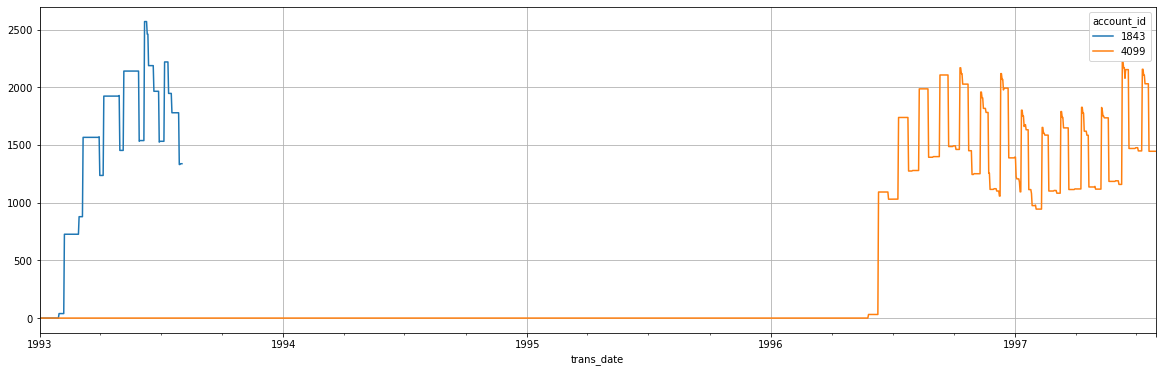

In [48]:
f = plt.figure(figsize=(20,6))
ax = f.add_subplot(111)
_ = transEUR[(transEUR.account_id=='1843') | (transEUR.account_id=='4099')]\
        .groupby(['trans_date','account_id'])\
        .agg({'balance_after_trans_EUR':lambda x: x.iloc[-1]})['balance_after_trans_EUR']\
        .unstack()\
        .plot(grid=True,ax = ax)

In [49]:
transEUR[(transEUR.account_id=='1843') & (transEUR.trans_id.astype(str)!='nan')].head(10)

trans_id account_id trans_date  trans_type  \
2912826   541681       1843 1993-01-30      CREDIT   
2912834   541683       1843 1993-02-07      CREDIT   
2912856   542076       1843 1993-03-01      CREDIT   
2912862   541684       1843 1993-03-07      CREDIT   
2912886   542077       1843 1993-03-31  WITHDRAWAL   
2912887  3591351       1843 1993-03-31      CREDIT   
2912894   541685       1843 1993-04-07      CREDIT   
2912917   542078       1843 1993-04-30  WITHDRAWAL   
2912918  3591352       1843 1993-04-30      CREDIT   
2912925   541686       1843 1993-05-07      CREDIT   

                    trans_operation  trans_amount  balance_after_trans  \
2912826              CREDIT_IN_CASH   1000.000000          1000.000000   
2912834  COLLECTION_FROM_OTHER_BANK  17632.000000         18632.000000   
2912856              CREDIT_IN_CASH   3900.000000         22532.000000   
2912862  COLLECTION_FROM_OTHER_BANK  17632.000000         40164.000000   
2912886          WITHDRAWAL_IN_CASH   8600.000000         31697.800781   
2912887                     UNKNOWN    133.800003         40297.800781   
2912894  COLLECTION_FROM_OTHER_BANK  17632.000000         49329.800781   
2912917          WITHDRAWAL_IN_CASH  12200.000000         37262.699219   
2912918                     UNKNOWN    132.800003         49462.699219   
2912925  COLLECTION_FROM_OTHER_BANK  17632.000000         54894.699219   

            trans_k_symbol trans_bank_partner  trans_account_partner  \
2912826            UNKNOWN                NaN                    NaN   
2912834            UNKNOWN                 QR             76294216.0   
2912856            UNKNOWN                NaN                    NaN   
2912862            UNKNOWN                 QR             76294216.0   
2912886            UNKNOWN                NaN                    NaN   
2912887  INTEREST_CREDITED                NaN                    NaN   
2912894            UNKNOWN                 QR             76294216.0   
2912917            UNKNOWN                NaN                    NaN   
2912918  INTEREST_CREDITED                NaN                    NaN   
2912925            UNKNOWN                 QR             76294216.0   

         trans_date_days  trans_amount_EUR  balance_after_trans_EUR client_id  \
2912826             29.0           39.0000                 39.00000      2235   
2912834             37.0          687.6480                726.64800      2235   
2912856             59.0          152.1000                878.74800      2235   
2912862             65.0          687.6480               1566.39600      2235   
2912886             89.0          335.4000               1236.21423      2235   
2912887             89.0            5.2182               1571.61423      2235   
2912894             96.0          687.6480               1923.86223      2235   
2912917            119.0          475.8000               1453.24527      2235   
2912918            119.0            5.1792               1929.04527      2235   
2912925            126.0          687.6480               2140.89327      2235   

        disp_type  loan_date  
2912826     OWNER 1993-08-03  
2912834     OWNER 1993-08-03  
2912856     OWNER 1993-08-03  
2912862     OWNER 1993-08-03  
2912886     OWNER 1993-08-03  
2912887     OWNER 1993-08-03  
2912894     OWNER 1993-08-03  
2912917     OWNER 1993-08-03  
2912918     OWNER 1993-08-03  
2912925     OWNER 1993-08-03

Recurrent periodic payments should appear by grouping the dataset by transaction amount. Therefore by grouping by transaction amount and by sorting by the number of transactions with a specific amount it is possible to quickly find all recurrent payments

In [50]:
tmp = transEUR[transEUR.account_id=='1843']\
        .groupby('trans_amount_EUR',as_index=False)\
        .agg({'trans_id':[('count',lambda x: len(list(x)))], 
              'trans_k_symbol':set,
              'trans_type':set,  
              'trans_operation':set})

tmp = to_flat_index(tmp)

tmp.sort_values(by=['trans_id_count'],ascending = False).head(10)

trans_amount_EUR  trans_id_count       trans_k_symbol_set trans_type_set  \
17          687.6480               5                {UNKNOWN}       {CREDIT}   
0             0.5694               2  {PAYMENT_FOR_STATEMENT}   {WITHDRAWAL}   
11          272.7660               2              {HOUSEHOLD}   {WITHDRAWAL}   
10          222.3000               1                {UNKNOWN}   {WITHDRAWAL}   
16          608.4000               1                {UNKNOWN}   {WITHDRAWAL}   
15          475.8000               1                {UNKNOWN}   {WITHDRAWAL}   
14          448.5000               1                {UNKNOWN}   {WITHDRAWAL}   
13          440.7000               1                {UNKNOWN}   {WITHDRAWAL}   
12          335.4000               1                {UNKNOWN}   {WITHDRAWAL}   
9           167.7000               1                {UNKNOWN}   {WITHDRAWAL}   

             trans_operation_set  
17  {COLLECTION_FROM_OTHER_BANK}  
0           {WITHDRAWAL_IN_CASH}  
11    {REMITTANCE_TO_OTHER_BANK}  
10          {WITHDRAWAL_IN_CASH}  
16          {WITHDRAWAL_IN_CASH}  
15          {WITHDRAWAL_IN_CASH}  
14          {WITHDRAWAL_IN_CASH}  
13          {WITHDRAWAL_IN_CASH}  
12          {WITHDRAWAL_IN_CASH}  
9           {WITHDRAWAL_IN_CASH}

In [51]:
orderEnriched[orderEnriched.account_id == '1843']

account_id  HOUSEHOLD_PAYMENT  LOAN_PAYMENT  UNKNOWN  INSURANCE_PAYMENT  \
843       1843         272.765991    114.609299      0.0                0.0   

     LEASING_PAYMENT  
843              0.0

we can find in the The amount paied for *HOUSEHOLD* in the transaction is compatible with the corresponding *HOUSEHOLD_PAYMENT* that is available in the *order's table*. In order to be sure that this is really a kind of rental expense we still have to check if *HOUSEHOLD* transactions have a monthly frequency.

In [52]:
transEUR[(transEUR.account_id=='1843') & (transEUR.trans_k_symbol=='HOUSEHOLD')].head(10)

trans_id account_id trans_date  trans_type           trans_operation  \
2912962   541831       1843 1993-06-13  WITHDRAWAL  REMITTANCE_TO_OTHER_BANK   
2912993   541832       1843 1993-07-13  WITHDRAWAL  REMITTANCE_TO_OTHER_BANK   

         trans_amount  balance_after_trans trans_k_symbol trans_bank_partner  \
2912962        6994.0         56104.500000      HOUSEHOLD                 QR   
2912993        6994.0         49929.199219      HOUSEHOLD                 QR   

         trans_account_partner  trans_date_days  trans_amount_EUR  \
2912962             62958740.0            163.0           272.766   
2912993             62958740.0            193.0           272.766   

         balance_after_trans_EUR client_id disp_type  loan_date  
2912962               2188.07550      2235     OWNER 1993-08-03  
2912993               1947.23877      2235     OWNER 1993-08-03

In [53]:
tmp = transEUR[(transEUR.account_id=='1843') & (transEUR.trans_type=='CREDIT')]\
        .groupby('trans_amount_EUR',as_index=False)\
        .agg({'trans_id':[('count',lambda x: len(list(x)))], 
              'trans_k_symbol':set,
              'trans_type':set,  
              'trans_operation':set})

tmp = to_flat_index(tmp)

tmp.sort_values(by=['trans_id_count'],ascending = False).head(10)

trans_amount_EUR  trans_id_count   trans_k_symbol_set trans_type_set  \
7          687.6480               5            {UNKNOWN}       {CREDIT}   
0            5.1792               1  {INTEREST_CREDITED}       {CREDIT}   
1            5.2182               1  {INTEREST_CREDITED}       {CREDIT}   
2            6.0762               1  {INTEREST_CREDITED}       {CREDIT}   
3            6.9459               1  {INTEREST_CREDITED}       {CREDIT}   
4            7.8507               1  {INTEREST_CREDITED}       {CREDIT}   
5           39.0000               1            {UNKNOWN}       {CREDIT}   
6          152.1000               1            {UNKNOWN}       {CREDIT}   
8         1031.4720               1            {UNKNOWN}       {CREDIT}   

            trans_operation_set  
7  {COLLECTION_FROM_OTHER_BANK}  
0                     {UNKNOWN}  
1                     {UNKNOWN}  
2                     {UNKNOWN}  
3                     {UNKNOWN}  
4                     {UNKNOWN}  
5              {CREDIT_IN_CASH}  
6              {CREDIT_IN_CASH}  
8  {COLLECTION_FROM_OTHER_BANK}

In [54]:
tmp = transEUR[(transEUR.account_id=='1843')].copy(deep=True)
tmp['month'] = tmp['trans_date'].apply(lambda x: str(x.month))

tmp[(tmp.account_id=='1843') & (tmp.trans_operation=='COLLECTION_FROM_OTHER_BANK')]\
    .groupby(['trans_amount_EUR','month']).agg({'trans_date':['count','min','max']})\
    .head(20)

trans_date                      
                            count        min        max
trans_amount_EUR month                                 
687.648          2              1 1993-02-07 1993-02-07
                 3              1 1993-03-07 1993-03-07
                 4              1 1993-04-07 1993-04-07
                 5              1 1993-05-07 1993-05-07
                 7              1 1993-07-07 1993-07-07
1031.472         6              1 1993-06-07 1993-06-07

If we plot the overall trend of all account balances it is clear that there are some account with negative balance.

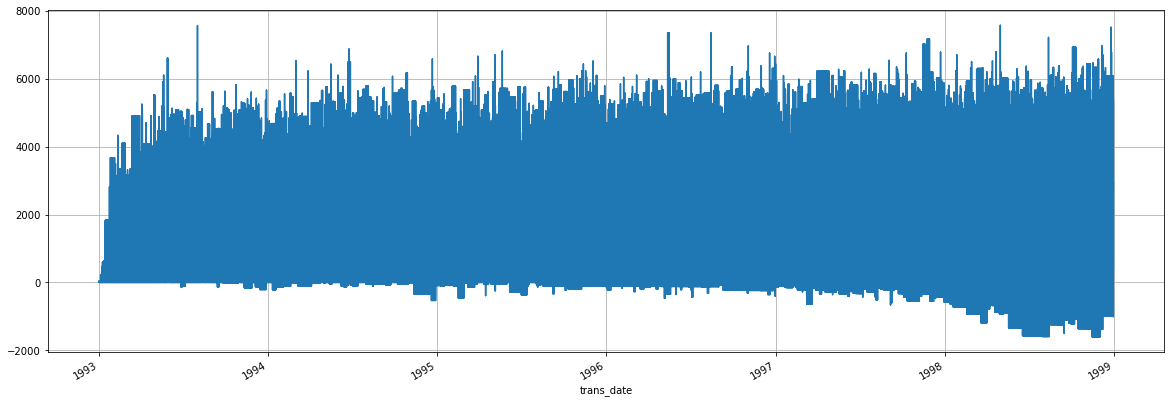

In [55]:
f = plt.figure(figsize=(20,7))
ax = f.add_subplot(111)
_ = transEUR.set_index('trans_date')['balance_after_trans_EUR'].plot(grid=True,ax=ax)

## Which features we could extract out of account balance trends?



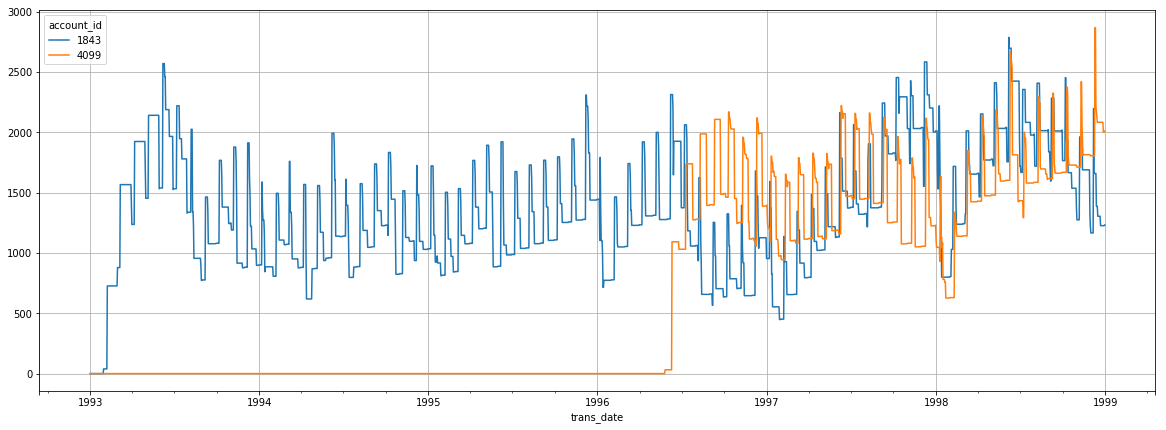

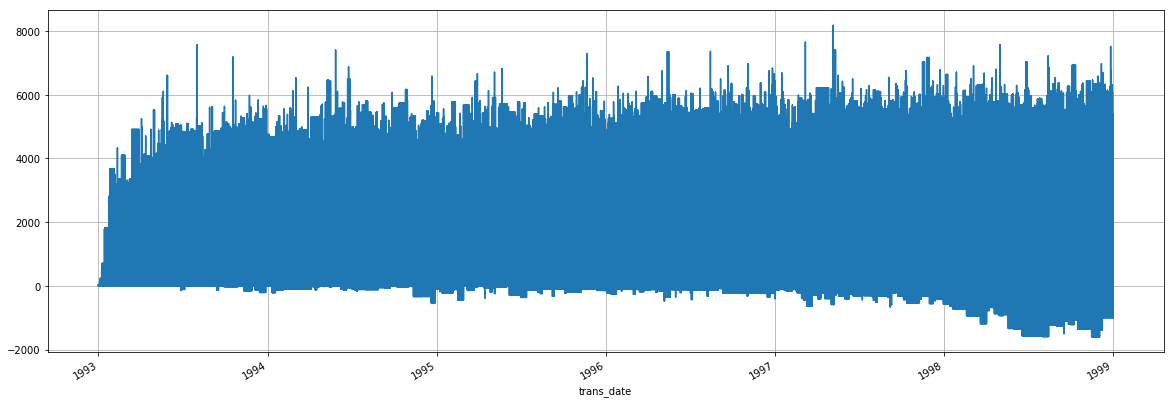

## Which features we could extract out of account balance trends?
**<mark>Task 5:</mark>**
1. Compute negative balance account statistics (a) and add them to the SCV (b): 
    - total number of days during which the account has a negative balance
    - average negative balance
2. Compute general account balance statistics (a) and add them to the SCV (b):
    - total number of transactions
    - account lifetime (in number of days)
    - account min, max, avg balance
    - average number of transactions per year
3. Compute statistics about salary (a) and add them to the SCV (b):
    - number of recieved salaries
    - min, max, avg salary

### Negative balance accounts

In [56]:
neg_balance = \
    transEUR[(transEUR.balance_after_trans_EUR<0)]\
        .groupby('account_id',as_index=False)\
        .agg({'trans_date':[('n_days_neg_balance','nunique')],
              'balance_after_trans_EUR':[('max_neg_balance',min),('avg_neg_balance','mean')]})

neg_balance = to_flat_index(neg_balance)
neg_balance.columns = ['account_id',
                       'n_days_neg_balance', 
                       'max_neg_balance', 
                       'avg_neg_balance']
neg_balance.head(10)

account_id  n_days_neg_balance  max_neg_balance  avg_neg_balance
0      10018                  24      -193.147500      -127.511473
1      10036                 362      -585.748808      -318.745859
2      10152                   6       -22.772101       -22.772101
3        102                   2      -277.040404      -277.040404
4      10220                  21       -19.180200       -18.237180
5      10227                  33       -19.055400       -15.572595
6      10343                 134      -380.519115      -204.170458
7      10365                  18       -28.025399       -27.855946
8      10558                  47      -184.259404       -73.689659
9      10562                  17       -23.630101        -5.888083

In [57]:
df['SCV'] = \
    pd  .merge(df['SCV'],
               neg_balance.drop('max_neg_balance',axis = 1),
               on = ['account_id'],
               how = "left")\
        .fillna({'n_days_neg_balance':0,'avg_neg_balance':0})

df['SCV'][df['SCV'].n_days_neg_balance>0].head(3)

account_id disp_id client_id disp_type  client_birth_number district_id  \
6       10018   12016     12324     OWNER               780306           8   
11      10036   12036     12344     OWNER               405620          26   
31      10152   12182     12490     OWNER               800814          34   

    client_age client_gender  loan_date  loan_amount  loan_duration  \
6    21.838356             M 2022-07-24          NaN            NaN   
11   59.572601             F 2022-07-24          NaN            NaN   
31   19.394520             M 2022-07-24          NaN            NaN   

    loan_monthly_payment loan_status  loan_date_days card_type card_issued  \
6                    NaN         NaN             NaN   no_card         NaT   
11                   NaN         NaN             NaN   no_card         NaT   
31                   NaN         NaN             NaN   no_card         NaT   

    card_issued_days  HOUSEHOLD_PAYMENT  LOAN_PAYMENT  UNKNOWN  \
6                NaN                0.0           0.0      0.0   
11               NaN                0.0           0.0      0.0   
31               NaN                0.0           0.0      0.0   

    INSURANCE_PAYMENT  LEASING_PAYMENT  n_days_neg_balance  avg_neg_balance  
6                 0.0         0.000000                24.0      -127.511473  
11                0.0       184.466095               362.0      -318.745859  
31                0.0         0.000000                 6.0       -22.772101

In [58]:
neg_balance[neg_balance.account_id=='3962']

account_id  n_days_neg_balance  max_neg_balance  avg_neg_balance
97       3962                  60            -50.7            -35.1

In [59]:
neg_balance.sort_values(by=['n_days_neg_balance'],ascending = False).head(10)

account_id  n_days_neg_balance  max_neg_balance  avg_neg_balance
86        3374                 817      -290.487596      -138.363017
55        2260                 651      -641.421270      -233.996401
58        2305                 639      -923.695500      -397.152572
138       5343                 608      -687.308730      -297.143384
131       5092                 517     -1346.307270      -690.597741
146       5429                 509     -1295.697000      -598.859085
112       4356                 392     -1382.807461      -504.437753
1        10036                 362      -585.748808      -318.745859
39        1539                 351      -548.460885      -205.656904
84        3326                 343     -1603.902270     -1035.352620

In [60]:
neg_balance.sort_values(by=['max_neg_balance'],ascending = True).head(10)


account_id  n_days_neg_balance  max_neg_balance  avg_neg_balance
84        3326                 343     -1603.902270     -1035.352620
112       4356                 392     -1382.807461      -504.437753
131       5092                 517     -1346.307270      -690.597741
146       5429                 509     -1295.697000      -598.859085
140       5366                 248      -998.770500      -355.116853
153       5661                 205      -937.610730      -291.732738
58        2305                 639      -923.695500      -397.152572
209       8341                 162      -853.487730      -270.635737
138       5343                 608      -687.308730      -297.143384
130        507                  96      -664.388385      -359.172146

In [61]:
neg_balance.sort_values(by=['avg_neg_balance'],ascending = True).head(10)


account_id  n_days_neg_balance  max_neg_balance  avg_neg_balance
84        3326                 343     -1603.902270     -1035.352620
131       5092                 517     -1346.307270      -690.597741
146       5429                 509     -1295.697000      -598.859085
112       4356                 392     -1382.807461      -504.437753
106       4128                  47      -487.305000      -442.212961
58        2305                 639      -923.695500      -397.152572
173       6463                  10      -468.659115      -394.294228
30        1330                   1      -365.562615      -365.562615
130        507                  96      -664.388385      -359.172146
140       5366                 248      -998.770500      -355.116853

### Accounts statistics

In [62]:
account_stats = \
    transEUR[transEUR.trans_id.astype(str) != 'nan']\
        .groupby('account_id',as_index = False)\
        .agg({'trans_id':[('n_transactions','nunique')],
              'trans_date':[('account_creation',min), ('account_last_activity',max)],
              'balance_after_trans_EUR':[('account_avg_bal','mean'),
                                         ('account_min_bal',min),
                                         ('account_max_bal',max)]})

account_stats = to_flat_index(account_stats)

account_stats.columns = ['account_id',
                         'n_transactions',
                         'account_creation',
                         'account_last_activity',
                         'account_avg_bal',
                         'account_min_bal',
                         'account_max_bal']

account_stats.head(10)

account_id  n_transactions account_creation account_last_activity  \
0          1             239       1995-03-24            1998-12-31   
1         10             156       1996-08-28            1998-12-31   
2        100             405       1993-12-28            1998-12-31   
3       1000             584       1993-01-25            1998-12-31   
4      10001              69       1995-05-28            1996-07-06   
5      10005              39       1997-11-29            1998-07-27   
6      10018             326       1995-07-23            1998-12-31   
7      10019              91       1995-06-15            1996-09-14   
8       1002             166       1996-09-17            1998-12-31   
9      10022              39       1997-05-07            1998-01-02   

   account_avg_bal  account_min_bal  account_max_bal  
0       623.766326          39.0000      1186.177230  
1      1863.892958          42.9000      3252.993961  
2      1645.339333          23.4000      3290.718539  
3      2257.829433           7.8000      3993.444000  
4      1681.748458          23.4000      2534.262961  
5      1995.832492           7.8000      3408.323039  
6       919.838295        -193.1475      2686.148461  
7      2210.121718          23.4000      5388.731156  
8       674.422798          19.5000      1160.468385  
9      2118.306793          15.6000      3161.464922

In [63]:
account_stats['account_life_days'] = \
    ((account_stats.account_last_activity - account_stats.account_creation)/np.timedelta64(1, 'D'))

account_stats['avg_trans_per_year'] = account_stats.n_transactions*365./account_stats.account_life_days

account_stats.head(10)

account_id  n_transactions account_creation account_last_activity  \
0          1             239       1995-03-24            1998-12-31   
1         10             156       1996-08-28            1998-12-31   
2        100             405       1993-12-28            1998-12-31   
3       1000             584       1993-01-25            1998-12-31   
4      10001              69       1995-05-28            1996-07-06   
5      10005              39       1997-11-29            1998-07-27   
6      10018             326       1995-07-23            1998-12-31   
7      10019              91       1995-06-15            1996-09-14   
8       1002             166       1996-09-17            1998-12-31   
9      10022              39       1997-05-07            1998-01-02   

   account_avg_bal  account_min_bal  account_max_bal  account_life_days  \
0       623.766326          39.0000      1186.177230             1378.0   
1      1863.892958          42.9000      3252.993961              855.0   
2      1645.339333          23.4000      3290.718539             1829.0   
3      2257.829433           7.8000      3993.444000             2166.0   
4      1681.748458          23.4000      2534.262961              405.0   
5      1995.832492           7.8000      3408.323039              240.0   
6       919.838295        -193.1475      2686.148461             1257.0   
7      2210.121718          23.4000      5388.731156              457.0   
8       674.422798          19.5000      1160.468385              835.0   
9      2118.306793          15.6000      3161.464922              240.0   

   avg_trans_per_year  
0           63.305515  
1           66.596491  
2           80.822854  
3           98.411819  
4           62.185185  
5           59.312500  
6           94.661893  
7           72.680525  
8           72.562874  
9           59.312500

Most of the accounts are still active in 1998 which is the last available year in the dataset

In [64]:
account_stats.sort_values(by=['account_last_activity'],ascending = True).head(10)

account_id  n_transactions account_creation account_last_activity  \
748        1787               4       1993-03-22            1993-06-20   
764        1801              37       1993-02-13            1993-07-09   
3519       9188              24       1993-02-08            1993-07-21   
797        1843              25       1993-01-30            1993-07-31   
164       11013              27       1993-02-14            1993-08-31   
199       11265              43       1993-01-14            1993-09-11   
2970       5428              32       1993-04-14            1993-09-21   
158       10973              32       1993-04-20            1993-10-08   
2873       4894              13       1993-06-20            1993-10-31   
2940       5270              53       1993-01-13            1993-11-16   

      account_avg_bal  account_min_bal  account_max_bal  account_life_days  \
748        477.750000           42.900       783.900000               90.0   
764       2031.270511           27.300      4699.999078              146.0   
3519      1172.377213           31.200      1934.025539              163.0   
797       1610.601714           39.000      2570.041500              182.0   
164       2230.340249           23.400      4792.830961              198.0   
199        865.728995           39.000      1617.294961              240.0   
2970      1461.932804           39.000      4119.492000              160.0   
158       1821.916204          346.983      3187.216500              171.0   
2873      1721.115627           31.200      3002.422922              133.0   
2940      2728.228303           31.200      4907.202422              307.0   

      avg_trans_per_year  
748            16.222222  
764            92.500000  
3519           53.742331  
797            50.137363  
164            49.772727  
199            65.395833  
2970           73.000000  
158            68.304094  
2873           35.676692  
2940           63.013029

In [65]:
df['SCV'] = pd.merge(df['SCV'], account_stats, on = ['account_id'], how = "left")
df['SCV'].head(5)

account_id disp_id client_id disp_type  client_birth_number district_id  \
0          1       1         1     OWNER               706213          18   
1         10      13        13     OWNER               745529          54   
2        100     121       121     OWNER               786029          41   
3       1000    1204      1204     OWNER               746109          77   
4      10001   11995     12303     OWNER               745405          24   

   client_age client_gender  loan_date  loan_amount  loan_duration  \
0   29.071234             F 2022-07-24          NaN            NaN   
1   25.610958             F 2022-07-24          NaN            NaN   
2   21.189041             F 2022-07-24          NaN            NaN   
3   25.161644             F 2022-07-24          NaN            NaN   
4   25.758904             F 1996-07-11      19044.0           36.0   

   loan_monthly_payment loan_status  loan_date_days card_type card_issued  \
0                   NaN         NaN             NaN   no_card         NaT   
1                   NaN         NaN             NaN   no_card         NaT   
2                   NaN         NaN             NaN   no_card         NaT   
3                   NaN         NaN             NaN   no_card         NaT   
4                 529.0           C          1287.0   no_card         NaT   

   card_issued_days  HOUSEHOLD_PAYMENT  LOAN_PAYMENT     UNKNOWN  \
0               NaN          95.627998      0.000000    0.000000   
1               NaN         274.287018      0.000000    0.000000   
2               NaN          23.322001      0.000000  285.830994   
3               NaN         123.981003      0.000000   57.525002   
4               NaN           0.000000     20.631001    0.000000   

   INSURANCE_PAYMENT  LEASING_PAYMENT  n_days_neg_balance  avg_neg_balance  \
0           0.000000            0.000                 0.0              0.0   
1           0.000000           52.416                 0.0              0.0   
2           0.000000            0.000                 0.0              0.0   
3         111.228004            0.000                 0.0              0.0   
4           0.000000            0.000                 0.0              0.0   

   n_transactions account_creation account_last_activity  account_avg_bal  \
0             239       1995-03-24            1998-12-31       623.766326   
1             156       1996-08-28            1998-12-31      1863.892958   
2             405       1993-12-28            1998-12-31      1645.339333   
3             584       1993-01-25            1998-12-31      2257.829433   
4              69       1995-05-28            1996-07-06      1681.748458   

   account_min_bal  account_max_bal  account_life_days  avg_trans_per_year  
0             39.0      1186.177230             1378.0           63.305515  
1             42.9      3252.993961              855.0           66.596491  
2             23.4      3290.718539             1829.0           80.822854  
3              7.8      3993.444000             2166.0           98.411819  
4             23.4      2534.262961              405.0           62.185185

### Salaries

In [66]:
salary = \
    transEUR[transEUR.trans_operation == 'COLLECTION_FROM_OTHER_BANK']\
        .groupby('account_id', as_index = False)\
        .agg({'trans_date':[('n_salaries','nunique'),('first_salary',min),('last_salary',max)],
              'trans_amount_EUR':[('avg_salary','mean'),
                                  ('min_salary',min),
                                  ('max_salary',max)]})

salary = to_flat_index(salary)
salary.columns = ['account_id', 
                  'n_salaries', 
                  'first_salary', 
                  'last_salary', 
                  'avg_salary', 
                  'min_salary', 
                  'max_salary']

salary.head(10)

account_id  n_salaries first_salary last_salary   avg_salary  min_salary  \
0          1          45   1995-04-13  1998-12-13   143.481000     143.481   
1       1000          71   1993-02-07  1998-12-07  1325.887944    1222.572   
2      10005           8   1997-12-08  1998-07-08  1541.114250    1369.875   
3      10022           7   1997-06-06  1997-12-06  1214.838857    1062.984   
4       1005          70   1993-03-09  1998-12-09  1460.105400    1344.837   
5       1006          70   1993-03-08  1998-12-08   145.743000     145.743   
6      10063           8   1996-11-06  1997-06-06  1706.825250    1517.178   
7       1008          27   1996-10-14  1998-12-14   230.178000     230.178   
8       1009          41   1995-08-11  1998-12-11  1874.724293    1727.271   
9       1011          12   1995-01-10  1995-12-10   862.023500     795.717   

   max_salary  
0     143.481  
1    1833.858  
2    2054.832  
3    1594.476  
4    2017.236  
5     145.743  
6    2275.767  
7     230.178  
8    2590.926  
9    1193.556

In [67]:
df['SCV'] = pd  .merge(df['SCV'],salary,on = ['account_id'],how = 'left')\
                .fillna({'n_salaries':0,'avg_salary':0,'min_salary':0,'max_salary':0})

df['SCV'].head(10)

account_id disp_id client_id disp_type  client_birth_number district_id  \
0          1       1         1     OWNER               706213          18   
1         10      13        13     OWNER               745529          54   
2        100     121       121     OWNER               786029          41   
3       1000    1204      1204     OWNER               746109          77   
4      10001   11995     12303     OWNER               745405          24   
5      10005   12000     12308     OWNER               781129          64   
6      10018   12016     12324     OWNER               780306           8   
7      10019   12017     12325     OWNER               641030           8   
8       1002    1206      1206     OWNER               570621          50   
9      10022   12020     12328     OWNER               445408           1   

   client_age client_gender  loan_date  loan_amount  loan_duration  \
0   29.071234             F 2022-07-24          NaN            NaN   
1   25.610958             F 2022-07-24          NaN            NaN   
2   21.189041             F 2022-07-24          NaN            NaN   
3   25.161644             F 2022-07-24          NaN            NaN   
4   25.758904             F 1996-07-11      19044.0           36.0   
5   21.104109             M 1998-07-29     210744.0           36.0   
6   21.838356             M 2022-07-24          NaN            NaN   
7   35.194519             M 1996-09-25     194940.0           36.0   
8   42.558903             M 2022-07-24          NaN            NaN   
9   55.769863             F 1998-01-03     218064.0           48.0   

   loan_monthly_payment loan_status  loan_date_days card_type card_issued  \
0                   NaN         NaN             NaN   no_card         NaT   
1                   NaN         NaN             NaN   no_card         NaT   
2                   NaN         NaN             NaN   no_card         NaT   
3                   NaN         NaN             NaN   no_card         NaT   
4                 529.0           C          1287.0   no_card         NaT   
5                5854.0           C          2035.0   no_card         NaT   
6                   NaN         NaN             NaN   no_card         NaT   
7                5415.0           C          1363.0   no_card         NaT   
8                   NaN         NaN             NaN   no_card         NaT   
9                4543.0           C          1828.0   no_card         NaT   

   card_issued_days  HOUSEHOLD_PAYMENT  LOAN_PAYMENT     UNKNOWN  \
0               NaN          95.627998      0.000000    0.000000   
1               NaN         274.287018      0.000000    0.000000   
2               NaN          23.322001      0.000000  285.830994   
3               NaN         123.981003      0.000000   57.525002   
4               NaN           0.000000     20.631001    0.000000   
5               NaN         356.889008    228.313812    0.000000   
6               NaN           0.000000      0.000000    0.000000   
7               NaN           0.000000    211.184998    0.000000   
8               NaN          50.427002      0.000000   42.588001   
9               NaN         299.442017    177.165314  160.056000   

   INSURANCE_PAYMENT  LEASING_PAYMENT  n_days_neg_balance  avg_neg_balance  \
0           0.000000            0.000                 0.0         0.000000   
1           0.000000           52.416                 0.0         0.000000   
2           0.000000            0.000                 0.0         0.000000   
3         111.228004            0.000                 0.0         0.000000   
4           0.000000            0.000                 0.0         0.000000   
5           0.000000            0.000                 0.0         0.000000   
6           0.000000            0.000                24.0      -127.511473   
7           0.000000            0.000                 0.0         0.000000   
8          18.330000            0.000                 0.0         0.000000   
9     

# Is there anything else we could extract?

### Trend analysis

We could try to find a way to describe the time series of the balance of each account by using some kind of features. There are several relevant behavioural information in trends, therefore we would like to extract them and use them in fourther analysis.

In [68]:
def plot_series(data,account_id,f,subplotID=111):
    points_data = \
        data[(data.account_id==account_id) & (data.trans_id.astype(str)!='nan')]\
                [['trans_date_days','balance_after_trans_EUR']].values
    
    points_norm = np.array(sorted( points_data,key=lambda x: x[0])) 
    ax = f.add_subplot(subplotID)
    ax.set_title("account_id: {0}".format(account_id))
    ax.plot(points_norm[:,0],points_norm[:,1],'-')
    ax.grid(which='both')

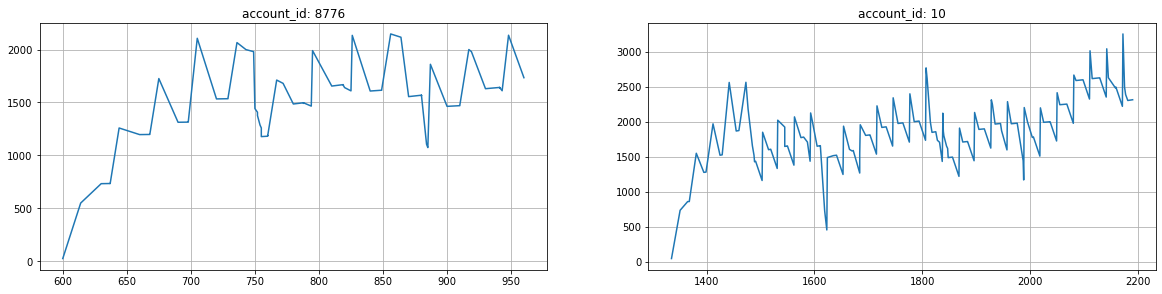

In [69]:
f = plt.figure(figsize=(20,10))
plot_series(transEUR,'8776',f,221)
plot_series(transEUR,'10',f,222)
plt.show()

Trend's features has to be time independent and scale independent. We only want to model the overall trend from the account creation to the last activity.

**<mark>Task 6:</mark>**
Implement a transformation that:
1. aggregate the ```transEUR``` by account. The aggregated dataframe will have 3 columns:
    - ```account_id```
    - ```x```: containing the list of all ```trans_date_days``` for each account
    - ```y```: containing the list of all ```balance_after_trans``` for each account
2. scale each ```x``` and ```y``` so that ```min(x)==0```, ```min(y)==0```, ```max(x)==100```, ```max(y)==100```. Scaled variables has to be saved respectively in ```norm_x``` and ```norm_y``` columns

In [70]:
def y_min_max_scaler(y,scale=1):
    max_ = max(y)
    min_ = min(y)
    return [scale*(float(entry)-min_)/(max_-min_) for entry in y]

trendsXYscaled = \
    transEUR[transEUR.trans_id.astype(str)!='nan']\
        .groupby('account_id', as_index=False)\
        .agg({'trans_date_days':[('x',list)],
              'balance_after_trans':[('y',list)]})

trendsXYscaled.columns = [col[1] if col[1]!='' else col[0] for col in trendsXYscaled.columns.to_flat_index()]

trendsXYscaled['norm_x'] = trendsXYscaled.x.apply(lambda x: y_min_max_scaler(x,100))
trendsXYscaled['norm_y'] = trendsXYscaled.y.apply(lambda x: y_min_max_scaler(x,100))

trendsXYscaled.head(5)                 

account_id                                                  x  \
0          1  [812.0, 832.0, 842.0, 849.0, 862.0, 872.0, 880...   
1         10  [1335.0, 1351.0, 1365.0, 1368.0, 1381.0, 1395....   
2        100  [361.0, 369.0, 391.0, 395.0, 400.0, 421.0, 423...   
3       1000  [24.0, 37.0, 54.0, 58.0, 65.0, 84.0, 89.0, 96....   
4      10001  [877.0, 886.0, 907.0, 910.0, 916.0, 937.0, 941...   

                                                   y  \
0  [1000.0, 4679.0, 17279.0, 17298.19921875, 2097...   
1  [1100.0, 18786.0, 21986.0, 21998.19921875, 396...   
2  [600.0, 12491.0, 18191.0, 18203.19921875, 3009...   
3  [200.0, 31548.0, 30048.0, 30070.30078125, 6141...   
4  [600.0, 24726.0, 25526.0, 25540.19921875, 4162...   

                                              norm_x  \
0  [0.0, 1.4513788098693758, 2.1770682148040637, ...   
1  [0.0, 1.871345029239766, 3.508771929824561, 3....   
2  [0.0, 0.43739748496446146, 1.6402405686167305,...   
3  [0.0, 0.6001846722068329, 1.3850415512465375, ...   
4  [0.0, 2.2222222222222223, 7.407407407407407, 8...   

                                              norm_y  
0  [0.0, 12.507308913494734, 55.3428871440013, 55...  
1  [0.0, 21.487034597534304, 25.374771265639573, ...  
2  [0.0, 14.19356559379315, 20.99730992855229, 21...  
3  [0.0, 30.6743903870993, 29.20662256839798, 29....  
4  [0.0, 37.473729735082145, 38.71633040606224, 3...

In [71]:
def plot_series(data, account_id, f, subplotID=111, x_lab='norm_x', y_lab='norm_y'):
    x_norm = data[data.account_id==account_id][x_lab].values[0]
    y_norm = data[data.account_id==account_id][y_lab].values[0]

    points_norm = np.array(sorted(list(zip(x_norm, y_norm)), key=lambda x: x[0]))

    ax = f.add_subplot(subplotID)
    ax.set_title("account_id: {0}".format(account_id))
    ax.plot(points_norm[:,0], points_norm[:,1], '-', label='points_norm')
    ax.grid(which='both')
    ax.legend()

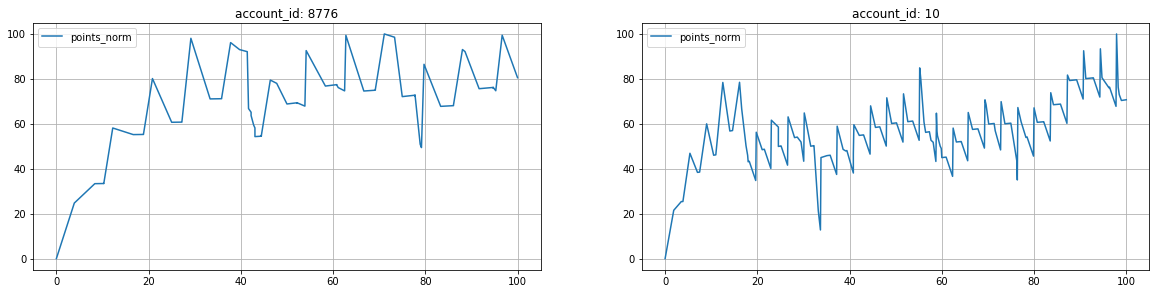

In [72]:
f = plt.figure(figsize=(20,10))
plot_series(trendsXYscaled, '8776', f, 221)
plot_series(trendsXYscaled, '10', f, 222)

Now that trends are normalized we can fit each trend and use the regression coefficients as feature to describe the trend.

**<mark>Task 7:</mark>** 
Implement a transformation that:
1. perform a linear fit for each account (by using the sci-kit learn LinearRegression) on ```norm_x``` and ```norm_y``` and save the regression coefficients sorted in increasing powers of ```x``` in a list in a new column named ```lin_fit_params```

2. do the same with a polinomial fit (degree 5) by using a sci-kit learn Pipeline with first a PolynomialFeatures and then the LinearRegression. Again the fit results have to be saved in a list sorted by increasing power of ```x``` in a new column named ```poli_fit_params```

In [73]:
def lin_fit(x,y):
    lm = LinearRegression(n_jobs=-1)
    lm = lm.fit(np.array(x).reshape(np.array(x).shape[0],1), np.array(y))
    return [float(lm.intercept_)] + [float(coeff) for coeff in lm.coef_]

def poli_fit(x,y):
    degree = 5
    lm = Pipeline(steps = [('PolynomialFeatures',PolynomialFeatures(degree, include_bias=False)),
                           ('Regression',LinearRegression())])
    
    lm = lm.fit(np.array(x).reshape(np.array(x).shape[0],1), np.array(y))
    return [float(lm.named_steps["Regression"].intercept_)] \
            + [float(coeff) for coeff in lm.named_steps["Regression"].coef_]



In [74]:
trendsFit = trendsXYscaled.copy(deep=True)
trendsFit['lin_fit_params']  = trendsFit.apply(lambda row: lin_fit(row.norm_x,row.norm_y), axis = 1)
trendsFit['poli_fit_params'] = trendsFit.apply(lambda row: poli_fit(row.norm_x,row.norm_y), axis = 1)
trendsFit.head(1)

account_id                                                  x  \
0          1  [812.0, 832.0, 842.0, 849.0, 862.0, 872.0, 880...   

                                                   y  \
0  [1000.0, 4679.0, 17279.0, 17298.19921875, 2097...   

                                              norm_x  \
0  [0.0, 1.4513788098693758, 2.1770682148040637, ...   

                                              norm_y  \
0  [0.0, 12.507308913494734, 55.3428871440013, 55...   

                              lin_fit_params  \
0  [59.28520042856251, -0.16508484065330825]   

                                     poli_fit_params  
0  [51.041802066490206, 3.1537912390570955, -0.20...

In [75]:
def residuals(x,y,model_params):
    y_pred = np.sum([np.power(x,par_idx)*model_params[par_idx] for par_idx in range(len(model_params))],
                    axis=0)
    res = (y-y_pred).tolist()
    return list(zip(x,res))

In [76]:
trendsFit['lin_fit_res'] = \
    trendsFit.apply(lambda row: residuals(row.norm_x,row.norm_y,row.lin_fit_params), axis = 1)

trendsFit['poli_fit_res'] = \
    trendsFit.apply(lambda row: residuals(row.norm_x,row.norm_y,row.poli_fit_params), axis = 1)


In [77]:
trendsFit.head(3)

account_id                                                  x  \
0          1  [812.0, 832.0, 842.0, 849.0, 862.0, 872.0, 880...   
1         10  [1335.0, 1351.0, 1365.0, 1368.0, 1381.0, 1395....   
2        100  [361.0, 369.0, 391.0, 395.0, 400.0, 421.0, 423...   

                                                   y  \
0  [1000.0, 4679.0, 17279.0, 17298.19921875, 2097...   
1  [1100.0, 18786.0, 21986.0, 21998.19921875, 396...   
2  [600.0, 12491.0, 18191.0, 18203.19921875, 3009...   

                                              norm_x  \
0  [0.0, 1.4513788098693758, 2.1770682148040637, ...   
1  [0.0, 1.871345029239766, 3.508771929824561, 3....   
2  [0.0, 0.43739748496446146, 1.6402405686167305,...   

                                              norm_y  \
0  [0.0, 12.507308913494734, 55.3428871440013, 55...   
1  [0.0, 21.487034597534304, 25.374771265639573, ...   
2  [0.0, 14.19356559379315, 20.99730992855229, 21...   

                              lin_fit_params  \
0  [59.28520042856251, -0.16508484065330825]   
1    [38.90985342917824, 0.3348216033512021]   
2    [30.15962937140223, 0.3787223134493073]   

                                     poli_fit_params  \
0  [51.041802066490206, 3.1537912390570955, -0.20...   
1  [15.258965916296638, 4.816237669231225, -0.224...   
2  [22.92242656668543, 3.3369645099431824, -0.236...   

                                         lin_fit_res  \
0  [(0.0, -59.28520042856251), (1.451378809869375...   
1  [(0.0, -38.90985342917824), (1.871345029239766...   
2  [(0.0, -30.15962937140223), (0.437397484964461...   

                                        poli_fit_res  
0  [(0.0, -51.041802066490206), (1.45137880986937...  
1  [(0.0, -15.258965916296638), (1.87134502923976...  
2  [(0.0, -22.92242656668543), (0.437397484964461...

In [78]:
def check_fit(data,account_id, f, subplotID=111):
    x_norm = data[data.account_id==account_id]['norm_x'].values[0]
    y_norm = data[data.account_id==account_id]['norm_y'].values[0]
    
    params_lin  = data[data.account_id==account_id]['lin_fit_params'].values[0]
    params_poli = data[data.account_id==account_id]['poli_fit_params'].values[0]
    
    points_norm = np.array(sorted(list(zip(x_norm,y_norm)), key=lambda x: x[0]))
    
    pred_lin  = params_lin[0] + points_norm[:,0]*params_lin[1]
    pred_poli = np.sum(
                        [np.power(points_norm[:,0],par_idx)*params_poli[par_idx] for par_idx in range(len(params_poli))],
                        axis=0
                        )

    ax = f.add_subplot(subplotID)
    ax.set_title("account_id:{0} - lin: {1}\npoli: {2}".format(account_id,
                                        ["{0:.4f}".format(bx*(10**bidx)) for bidx,bx in enumerate(params_lin)],
                                        ["{0:.4f}".format(x*(10**idx)) for idx,x in enumerate(params_poli)]))
    ax.plot(points_norm[:,0],points_norm[:,1],'-',label='points_norm')
    ax.plot(points_norm[:,0],pred_lin,'-',label='points_pred_lin')
    ax.plot(points_norm[:,0],pred_poli,'-',label='points_pred_poli')
    ax.grid(which='both')
    ax.legend()

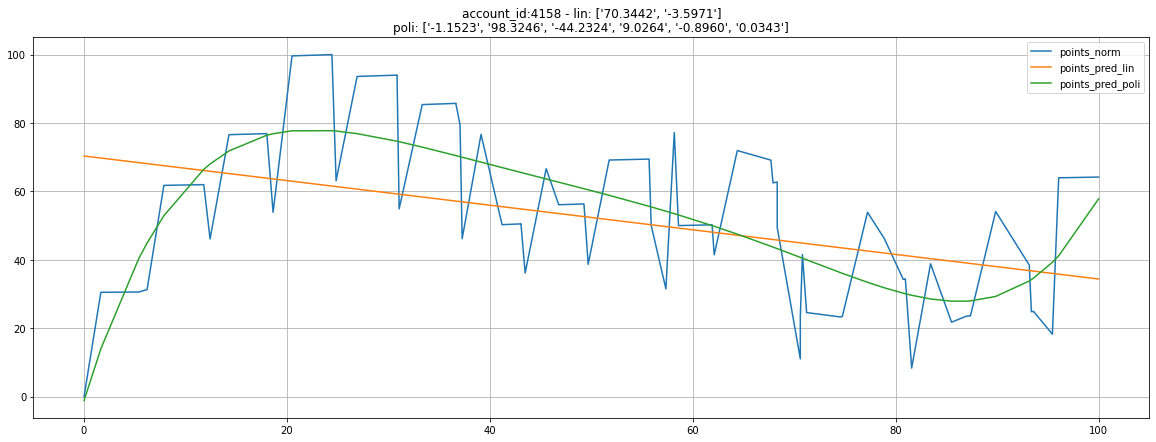

In [79]:
test_account_ID = '4158' #2122(flat),1720(dec trend),3888(dec trend), 4158(short time dec trend)

f = plt.figure(figsize=(20,7))
check_fit(trendsFit,test_account_ID,f,111)

In [80]:
def plot_residual(dataset,col_name,fig,subplotID,sample=0.2,seed=0):
    data = np.array([pair for res_list in dataset[col_name].sample(frac=0.2).values for pair in res_list])
    positive_frac = 100.*float(np.where(data[:,1]>0,1,0).sum())/float(data.shape[0])
    ax = f.add_subplot(subplotID)
    ax.scatter(data[:,0],data[:,1],s=1)
    ax.plot([0,100],[0,0],'--',c='red')
    ax.set_title("{0} - positive residual rate: {1:.0f}%".format(col_name,positive_frac))
    ax.set_xlabel('scaled time')
    ax.set_ylabel('resitual')
    ax.grid(which='both')   

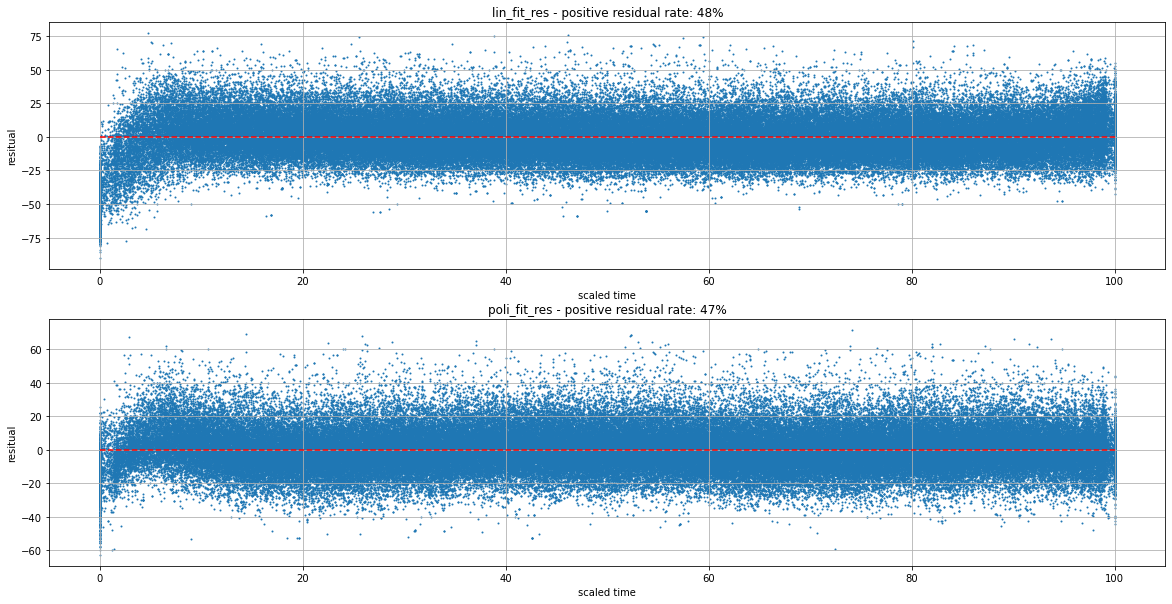

In [81]:
f = plt.figure(figsize=(20,10))
plot_residual(trendsFit,'lin_fit_res',f,211,1.)
plot_residual(trendsFit,'poli_fit_res',f,212,1.)

# Base table finalization

In [82]:
lin  = np.array(trendsFit['lin_fit_params'].values.tolist())
poli = np.array(trendsFit['poli_fit_params'].values.tolist())
account_id = trendsFit['account_id'].copy(deep=True)

df_lin  = pd.DataFrame(data=lin, columns=['lin_fit_params_{0}'.format(x) for x in range(lin.shape[1])])
df_poli = pd.DataFrame(data=poli, columns=['poli_fit_params_{0}'.format(x) for x in range(poli.shape[1])])
df_trendsFit = pd.merge(df_lin,df_poli,left_index=True,right_index=True)
df_trendsFit['account_id'] = account_id
cols = df_trendsFit.columns[-1:].tolist() + df_trendsFit.columns[:-1].tolist()
df_trendsFit = df_trendsFit[cols]
df_trendsFit.head(1)

account_id  lin_fit_params_0  lin_fit_params_1  poli_fit_params_0  \
0          1           59.2852         -0.165085          51.041802   

   poli_fit_params_1  poli_fit_params_2  poli_fit_params_3  poli_fit_params_4  \
0           3.153791          -0.206411           0.004589          -0.000043   

   poli_fit_params_5  
0       1.445550e-07

In [83]:
df['SCV'] = pd.merge(df['SCV'],df_trendsFit,on = ['account_id'],how = 'left')
df['SCV'].head(10)

account_id disp_id client_id disp_type  client_birth_number district_id  \
0          1       1         1     OWNER               706213          18   
1         10      13        13     OWNER               745529          54   
2        100     121       121     OWNER               786029          41   
3       1000    1204      1204     OWNER               746109          77   
4      10001   11995     12303     OWNER               745405          24   
5      10005   12000     12308     OWNER               781129          64   
6      10018   12016     12324     OWNER               780306           8   
7      10019   12017     12325     OWNER               641030           8   
8       1002    1206      1206     OWNER               570621          50   
9      10022   12020     12328     OWNER               445408           1   

   client_age client_gender  loan_date  loan_amount  loan_duration  \
0   29.071234             F 2022-07-24          NaN            NaN   
1   25.610958             F 2022-07-24          NaN            NaN   
2   21.189041             F 2022-07-24          NaN            NaN   
3   25.161644             F 2022-07-24          NaN            NaN   
4   25.758904             F 1996-07-11      19044.0           36.0   
5   21.104109             M 1998-07-29     210744.0           36.0   
6   21.838356             M 2022-07-24          NaN            NaN   
7   35.194519             M 1996-09-25     194940.0           36.0   
8   42.558903             M 2022-07-24          NaN            NaN   
9   55.769863             F 1998-01-03     218064.0           48.0   

   loan_monthly_payment loan_status  loan_date_days card_type card_issued  \
0                   NaN         NaN             NaN   no_card         NaT   
1                   NaN         NaN             NaN   no_card         NaT   
2                   NaN         NaN             NaN   no_card         NaT   
3                   NaN         NaN             NaN   no_card         NaT   
4                 529.0           C          1287.0   no_card         NaT   
5                5854.0           C          2035.0   no_card         NaT   
6                   NaN         NaN             NaN   no_card         NaT   
7                5415.0           C          1363.0   no_card         NaT   
8                   NaN         NaN             NaN   no_card         NaT   
9                4543.0           C          1828.0   no_card         NaT   

   card_issued_days  HOUSEHOLD_PAYMENT  LOAN_PAYMENT     UNKNOWN  \
0               NaN          95.627998      0.000000    0.000000   
1               NaN         274.287018      0.000000    0.000000   
2               NaN          23.322001      0.000000  285.830994   
3               NaN         123.981003      0.000000   57.525002   
4               NaN           0.000000     20.631001    0.000000   
5               NaN         356.889008    228.313812    0.000000   
6               NaN           0.000000      0.000000    0.000000   
7               NaN           0.000000    211.184998    0.000000   
8               NaN          50.427002      0.000000   42.588001   
9               NaN         299.442017    177.165314  160.056000   

   INSURANCE_PAYMENT  LEASING_PAYMENT  n_days_neg_balance  avg_neg_balance  \
0           0.000000            0.000                 0.0         0.000000   
1           0.000000           52.416                 0.0         0.000000   
2           0.000000            0.000                 0.0         0.000000   
3         111.228004            0.000                 0.0         0.000000   
4           0.000000            0.000                 0.0         0.000000   
5           0.000000            0.000                 0.0         0.000000   
6           0.000000            0.000                24.0      -127.511473   
7           0.000000            0.000                 0.0         0.000000   
8          18.330000            0.000                 0.0         0.000000   
9     

In [84]:
#Computing the model target: any customer who bought a loan

df['SCV']['target'] = df['SCV']['loan_status'].astype(str).apply(lambda x: int(x!='nan'))
df['SCV'].head(10)

account_id disp_id client_id disp_type  client_birth_number district_id  \
0          1       1         1     OWNER               706213          18   
1         10      13        13     OWNER               745529          54   
2        100     121       121     OWNER               786029          41   
3       1000    1204      1204     OWNER               746109          77   
4      10001   11995     12303     OWNER               745405          24   
5      10005   12000     12308     OWNER               781129          64   
6      10018   12016     12324     OWNER               780306           8   
7      10019   12017     12325     OWNER               641030           8   
8       1002    1206      1206     OWNER               570621          50   
9      10022   12020     12328     OWNER               445408           1   

   client_age client_gender  loan_date  loan_amount  loan_duration  \
0   29.071234             F 2022-07-24          NaN            NaN   
1   25.610958             F 2022-07-24          NaN            NaN   
2   21.189041             F 2022-07-24          NaN            NaN   
3   25.161644             F 2022-07-24          NaN            NaN   
4   25.758904             F 1996-07-11      19044.0           36.0   
5   21.104109             M 1998-07-29     210744.0           36.0   
6   21.838356             M 2022-07-24          NaN            NaN   
7   35.194519             M 1996-09-25     194940.0           36.0   
8   42.558903             M 2022-07-24          NaN            NaN   
9   55.769863             F 1998-01-03     218064.0           48.0   

   loan_monthly_payment loan_status  loan_date_days card_type card_issued  \
0                   NaN         NaN             NaN   no_card         NaT   
1                   NaN         NaN             NaN   no_card         NaT   
2                   NaN         NaN             NaN   no_card         NaT   
3                   NaN         NaN             NaN   no_card         NaT   
4                 529.0           C          1287.0   no_card         NaT   
5                5854.0           C          2035.0   no_card         NaT   
6                   NaN         NaN             NaN   no_card         NaT   
7                5415.0           C          1363.0   no_card         NaT   
8                   NaN         NaN             NaN   no_card         NaT   
9                4543.0           C          1828.0   no_card         NaT   

   card_issued_days  HOUSEHOLD_PAYMENT  LOAN_PAYMENT     UNKNOWN  \
0               NaN          95.627998      0.000000    0.000000   
1               NaN         274.287018      0.000000    0.000000   
2               NaN          23.322001      0.000000  285.830994   
3               NaN         123.981003      0.000000   57.525002   
4               NaN           0.000000     20.631001    0.000000   
5               NaN         356.889008    228.313812    0.000000   
6               NaN           0.000000      0.000000    0.000000   
7               NaN           0.000000    211.184998    0.000000   
8               NaN          50.427002      0.000000   42.588001   
9               NaN         299.442017    177.165314  160.056000   

   INSURANCE_PAYMENT  LEASING_PAYMENT  n_days_neg_balance  avg_neg_balance  \
0           0.000000            0.000                 0.0         0.000000   
1           0.000000           52.416                 0.0         0.000000   
2           0.000000            0.000                 0.0         0.000000   
3         111.228004            0.000                 0.0         0.000000   
4           0.000000            0.000                 0.0         0.000000   
5           0.000000            0.000                 0.0         0.000000   
6           0.000000            0.000                24.0      -127.511473   
7           0.000000            0.000                 0.0         0.000000   
8          18.330000            0.000                 0.0         0.000000   
9     

# Model Pipeline

Build a classification model to predict whether a customer is about to request a loan 
- Build the proper data preprocessing pipeline
  

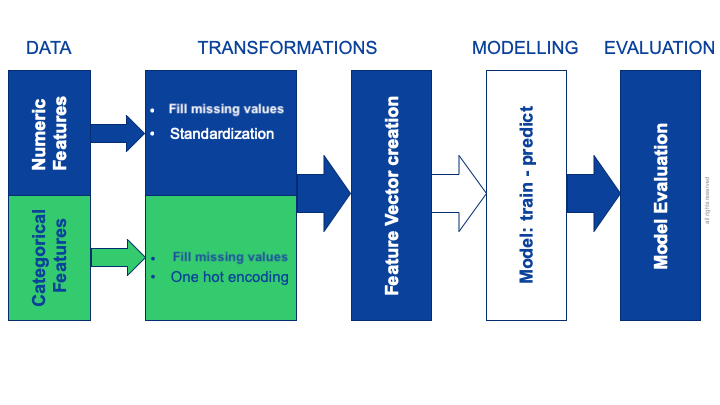


- Split data into training and test set
- Check if the target variable is balanced or unbalanced 
    - how many accounts have target 0?
    - how many have target 1?
    - how can we rebalance to a 50%-50% ratio between target 0 and target 1?
- While building the classification model be aware that some variables (e.g. `account_life_days`) are biased twords the target due to the fact that we artificially cut-off the transaction timeseries ***only*** for custumers with a loan and not for those without.
    - Try to train a simple logistic regression model including those variables and verify that:
        - The model will have a performance definitely too high
        - The variables with a bias towards the target will have a feature importance much higher than anything else
    - Remove those variables train a logistic regression:
        1. without rebalancing the dataset
        2. by rebalancing the dataset (how would you rebalance? undersampling? oversampling? both? cost sensitive learning using the `class_weight='balanced'` option?
        3. What is the impact of rebalancing on the probability distribution of the minority class? 
- Optimize hyperparameters and train a Decision Tree model and a Random Forest model
    - Which is the most performing model?
    - Which are the most important features?        

In [85]:
## Useful items 
'''
Here you can find some useful helping functions 
to plot model probability distribution and results 
of the grid search
'''

def evaluate_model_stability(training_target0_proba,training_target1_proba,
                             test_target0_proba,test_target1_proba):
    '''
    Function to plot and compare the probability distribution
    of the training and test set.
    
    training_target0_proba: 
        vector with the probability to belong to class 1 for 
        events belonging to groundtrue class 0 in the training 
        set.
    training_target1_proba: 
        vector with the probability to belong to class 1 for 
        events belonging to groundtrue class 1 in the training 
        set.
    test_target0_proba: 
        vector with the probability to belong to class 1 for 
        events belonging to groundtrue class 0 in the test 
        set.
    test_target1_proba: 
        vector with the probability to belong to class 1 for 
        events belonging to groundtrue class 1 in the test 
        set.
    
    '''
    
    tr_target_0 = training_target0_proba
    tr_target_1 = training_target1_proba

    te_target_0 = test_target0_proba
    te_target_1 = test_target1_proba


    f = plt.figure(figsize=(20,14))
    ax = f.add_subplot(321)
    tr_h1_y_full,_,_ = ax.hist(tr_target_0, bins = np.arange(0,1,0.05), alpha = 0.5)
    tr_h2_y_full,_,_ = ax.hist(tr_target_1, bins = np.arange(0,1,0.05), alpha = 0.5)
    ax.set_ylabel('Number of Events')
    ax.set_xlabel('Probability of target 1')
    ax.set_title('Training set')
    ax.grid(which='both')
    ax.set_yscale('log')
    ax = f.add_subplot(322)
    te_h1_y_full,_,_ = ax.hist(te_target_0, bins = np.arange(0,1,0.05), alpha = 0.5)
    te_h2_y_full,_,_ = ax.hist(te_target_1, bins = np.arange(0,1,0.05), alpha = 0.5)
    ax.set_ylabel('Number of Events')
    ax.set_xlabel('Probability of target 1')
    ax.set_title('Test set')
    ax.grid(which='both')
    ax.set_yscale('log')
    
    ax = f.add_subplot(323)
    w_tr_target_0 = [1./tr_target_0.shape[0]]*tr_target_0.shape[0]
    w_te_target_0 = [1./te_target_0.shape[0]]*te_target_0.shape[0]
    w_tr_target_1 = [1./tr_target_1.shape[0]]*tr_target_1.shape[0]
    w_te_target_1 = [1./te_target_1.shape[0]]*te_target_1.shape[0]

    tr_h1_y,_,_ = ax.hist(tr_target_0, bins = np.arange(0,1,0.05), 
                          alpha = 0.5, facecolor='C0', weights=w_tr_target_0, label='train data')
    te_h1_y,_,_ = ax.hist(te_target_0, bins = np.arange(0,1,0.05), 
                          alpha = 1, color='C0',histtype='step',linewidth = 2, 
                          linestyle='--', weights=w_te_target_0, label='test data')
    ax.set_ylabel('Number of Events')
    ax.set_xlabel('Probability of target 1')
    ax.set_title('Target 0 events')
    ax.grid(which='both')
    ax.legend()


    ax = f.add_subplot(324)
    tr_h2_y,_,_ = ax.hist(tr_target_1, bins = np.arange(0,1,0.05), 
                          alpha = 0.5, facecolor='C1', weights=w_tr_target_1,  label='train data')
    te_h2_y,_,_ = ax.hist(te_target_1, bins = np.arange(0,1,0.05), alpha = 1, 
                          color='C1',histtype='step',linewidth = 2, linestyle='--', weights=w_te_target_1, label='test data')
    ax.set_ylabel('Number of Events')
    ax.set_xlabel('Probability of target 1')
    ax.set_title('Target 1 events')
    ax.grid(which='both')
    ax.legend()

    x = (np.arange(0,1,0.05)[1:]+np.arange(0,1,0.05)[:-1])/2.

    ax = f.add_subplot(3,2,(5,6))
    y1 = tr_h1_y - te_h1_y
    y1_err = np.sqrt(tr_h1_y_full/tr_target_0.shape[0]**2+te_h1_y_full/te_target_0.shape[0]**2)

    y2 = tr_h2_y - te_h2_y
    y2_err = np.sqrt(tr_h2_y_full/tr_target_1.shape[0]**2+te_h2_y_full/te_target_1.shape[0]**2)

    ax.plot(x, y1,'.-', label = 'target 0', c='C0')
    ax.fill_between(x.astype(float),(y1-y1_err).astype(float),(y1+y1_err).astype(float),facecolor='C0', alpha=0.3)
    
    ax.plot(x, y2,'.-', label = 'target 1', c='C1')
    ax.fill_between(x.astype(float),(y2-y2_err).astype(float),(y2+y2_err).astype(float),facecolor='C1', alpha=0.1)
    ax.plot(x, [0]*x.shape[0], '--', c='red')

    ax.set_ylabel('Train - Test')
    ax.set_xlabel('Probability of target 1')
    ax.xaxis.set_ticks(np.arange(0.0, 1.0, 0.05))
    ax.grid(which='both')
    text =  "Kolmogorov-Smirnov test"
    text += "\n-p_val(Target 0): {0:.3f}".format(ks_2samp(tr_h1_y, te_h1_y).pvalue)
    text += "\n-p_val(Target 1): {0:.3f}".format(ks_2samp(tr_h2_y, te_h2_y).pvalue)
    ax.text(0.5, 0.9, text, fontsize=14,transform = ax.transAxes,
         horizontalalignment='center',
         verticalalignment='center',
         bbox=dict(boxstyle="square",
                   fc=(1., 1., 1.)))
    ax.legend(loc='upper right', shadow=True, fontsize='x-large')

def plot(fig ,x ,y ,x_label ,y_label ,title, IID):
    '''
    simple function to produce plots in 1 line
    '''
    ax = fig.add_subplot(IID)
    ax.plot(x,y)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.grid(which='both')
    return ax


def plot_gs_results(param_grid,results,key1,key2,metric_name):
    '''
    Function to plot the grid-search results. This function is designed only
    to allow the simultaneous variation of 2 hyperparameters of the model.
    Therefore if you ran a GridSearch with more than 2 free parameters 
    before using this function you should decide which are the 2 hyperparameters
    that you want to visualize and fix the value of all the other hyperparameters
    by filtering the results dataframe.
    
    i.e.
    param_grid = {
        'classifier__max_depth':range(3,20),
        'classifier__min_samples_split': [5,10,15,20],
        'classifier__criterion':["gini", "entropy"]}
    
    #select the two params that you want to visualize
    filtered_param_grid = param_grid.copy()
    filtered_param_grid.pop('classifier__criterion')
    
    #fix one value for each param that you don't want to visualize
    filtered_results = results[results.param_classifier__criterion == 'gini']
    
    #plot results
    plot_gs_results(filtered_param_grid,
                    filtered_results,
                    'param_classifier__min_samples_split',
                    'param_classifier__max_depth',
                    'f1')
    '''
    
    f = plt.figure(figsize=(20,12))
    clrs = sns.color_palette("husl", max(len(param_grid[key1[6:]]),
                                         len(param_grid[key2[6:]])))

    ax = f.add_subplot(221)
    for idx,mss in enumerate(param_grid[key1[6:]]):
        x = results[results[key1]==mss][key2]
        y = results[results[key1]==mss]['mean_test_'+metric_name]
        y_err = results[results[key1]==mss]['std_test_'+metric_name]
        ax.plot(x,y,'.-',label='{0} = {1}'.format(key1.split('__')[1],mss),markersize=12, c=clrs[idx])
        ax.fill_between(x.astype(float),(y-y_err).astype(float),(y+y_err).astype(float),facecolor=clrs[idx], alpha=0.1)
    ax.set_ylabel('mean_test_'+metric_name)
    ax.set_xlabel(key2.split('__')[1])
    ax.grid(which='both')
    ax.legend()
    ax = f.add_subplot(222)
    for idx,md in enumerate(param_grid[key2[6:]]):
        x = results[results[key2]==md][key1]
        y = results[results[key2]==md]['mean_test_'+metric_name]
        y_err = results[results[key2]==md]['std_test_'+metric_name]
        ax.plot(x,y,'.-',label='{0} = {1}'.format(key2.split('__')[1],md),markersize=12, c=clrs[idx])
        ax.fill_between(x.astype(float),(y-y_err).astype(float),(y+y_err).astype(float),facecolor=clrs[idx], alpha=0.1)
    ax.set_ylabel('mean_test_'+metric_name)
    ax.set_xlabel(key1.split('__')[1])
    ax.grid(which='both')
    ax.legend()


    ax = f.add_subplot(223)
    for idx,mss in enumerate(param_grid[key1[6:]]):
        x = results[results[key1]==mss][key2]
        n = results[results[key1]==mss]['mean_test_'+metric_name]
        s_n = results[results[key1]==mss]['std_test_'+metric_name]
        d = results[results[key1]==mss]['mean_train_'+metric_name]
        s_d = results[results[key1]==mss]['std_train_'+metric_name]
        y = n / d
        y_err = np.sqrt((s_n/d)*(s_n/d)+(n*s_d/(d*d))*(n*s_d/(d*d))) 
        ax.plot(x,y,'.-',label='{0} = {1}'.format(key1.split('__')[1],mss),markersize=12,c=clrs[idx])
        ax.fill_between(x.astype(float),(y-y_err).astype(float),(y+y_err).astype(float),facecolor=clrs[idx], alpha=0.1)
    
    ax.set_ylabel('training/test (mean_test_{0})'.format(metric_name))
    ax.set_xlabel(key2.split('__')[1])
    ax.grid(which='both')
    ax.legend()

    ax = f.add_subplot(224)
    for idx,md in enumerate(param_grid[key2[6:]]):
        x = results[results[key2]==md][key1]
        y = results[results[key2]==md]['mean_test_'+metric_name] / \
            results[results[key2]==md]['mean_train_'+metric_name]
        
        n = results[results[key2]==md]['mean_test_'+metric_name]
        s_n = results[results[key2]==md]['std_test_'+metric_name]
        d = results[results[key2]==md]['mean_train_'+metric_name]
        s_d = results[results[key2]==md]['std_train_'+metric_name]
        y = n / d
        y_err = np.sqrt((s_n/d)*(s_n/d)+(n*s_d/(d*d))*(n*s_d/(d*d))) 
        ax.plot(x,y,'.-',label='{0} = {1}'.format(key2.split('__')[1],md),markersize=12,c=clrs[idx])
        ax.fill_between(x.astype(float),(y-y_err).astype(float),(y+y_err).astype(float),facecolor=clrs[idx], alpha=0.1)
    ax.set_ylabel('training/test (mean_test_{0})'.format(metric_name))
    ax.set_xlabel(key1.split('__')[1])
    ax.grid(which='both')
    ax.legend()
    plt.show()

<span style="color:red"><font size="5">
    ***IMPLEMENT YOUR MODELLING PIPELINE BELOW***
</font> </span>.

**Data processing pipeline**

In [86]:
#checking umbalance in the dataset
print('There are # customers not asking for loan:', np.where(df['SCV']['target']==0)[0].size) #customer not asking for a loan
print('There are # customers asking for loan:', np.where(df['SCV']['target']==1)[0].size) #customers asking for a loan

There are # customers not asking for loan: 3094
There are # customers asking for loan: 537


therefore we can adfirm that the dataset is very unbalanced

In [87]:

df['SCV'].head(2)


account_id disp_id client_id disp_type  client_birth_number district_id  \
0          1       1         1     OWNER               706213          18   
1         10      13        13     OWNER               745529          54   

   client_age client_gender  loan_date  loan_amount  loan_duration  \
0   29.071234             F 2022-07-24          NaN            NaN   
1   25.610958             F 2022-07-24          NaN            NaN   

   loan_monthly_payment loan_status  loan_date_days card_type card_issued  \
0                   NaN         NaN             NaN   no_card         NaT   
1                   NaN         NaN             NaN   no_card         NaT   

   card_issued_days  HOUSEHOLD_PAYMENT  LOAN_PAYMENT  UNKNOWN  \
0               NaN          95.627998           0.0      0.0   
1               NaN         274.287018           0.0      0.0   

   INSURANCE_PAYMENT  LEASING_PAYMENT  n_days_neg_balance  avg_neg_balance  \
0                0.0            0.000                 0.0              0.0   
1                0.0           52.416                 0.0              0.0   

   n_transactions account_creation account_last_activity  account_avg_bal  \
0             239       1995-03-24            1998-12-31       623.766326   
1             156       1996-08-28            1998-12-31      1863.892958   

   account_min_bal  account_max_bal  account_life_days  avg_trans_per_year  \
0             39.0      1186.177230             1378.0           63.305515   
1             42.9      3252.993961              855.0           66.596491   

   n_salaries first_salary last_salary  avg_salary  min_salary  max_salary  \
0        45.0   1995-04-13  1998-12-13     143.481     143.481     143.481   
1         0.0          NaT         NaT       0.000       0.000       0.000   

   lin_fit_params_0  lin_fit_params_1  poli_fit_params_0  poli_fit_params_1  \
0         59.285200         -0.165085          51.041802           3.153791   
1         38.909853          0.334822          15.258966           4.816238   

   poli_fit_params_2  poli_fit_params_3  poli_fit_params_4  poli_fit_params_5  \
0          -0.206411           0.004589          -0.000043       1.445550e-07   
1          -0.224063           0.004673          -0.000044       1.600936e-07   

   target  
0       0  
1       0

In [88]:
df_SCV_new = df['SCV'].drop(columns=['loan_amount','loan_duration', 'loan_monthly_payment',	'loan_status', 	'loan_date_days'])
df_SCV_new = df_SCV_new.drop(columns=['LOAN_PAYMENT'])

In [89]:
df_SCV_new = df_SCV_new.drop(columns=['loan_date','disp_type','account_id','disp_id','client_id'])
df_SCV_new.head(2)

client_birth_number district_id  client_age client_gender card_type  \
0               706213          18   29.071234             F   no_card   
1               745529          54   25.610958             F   no_card   

  card_issued  card_issued_days  HOUSEHOLD_PAYMENT  UNKNOWN  \
0         NaT               NaN          95.627998      0.0   
1         NaT               NaN         274.287018      0.0   

   INSURANCE_PAYMENT  LEASING_PAYMENT  n_days_neg_balance  avg_neg_balance  \
0                0.0            0.000                 0.0              0.0   
1                0.0           52.416                 0.0              0.0   

   n_transactions account_creation account_last_activity  account_avg_bal  \
0             239       1995-03-24            1998-12-31       623.766326   
1             156       1996-08-28            1998-12-31      1863.892958   

   account_min_bal  account_max_bal  account_life_days  avg_trans_per_year  \
0             39.0      1186.177230             1378.0           63.305515   
1             42.9      3252.993961              855.0           66.596491   

   n_salaries first_salary last_salary  avg_salary  min_salary  max_salary  \
0        45.0   1995-04-13  1998-12-13     143.481     143.481     143.481   
1         0.0          NaT         NaT       0.000       0.000       0.000   

   lin_fit_params_0  lin_fit_params_1  poli_fit_params_0  poli_fit_params_1  \
0         59.285200         -0.165085          51.041802           3.153791   
1         38.909853          0.334822          15.258966           4.816238   

   poli_fit_params_2  poli_fit_params_3  poli_fit_params_4  poli_fit_params_5  \
0          -0.206411           0.004589          -0.000043       1.445550e-07   
1          -0.224063           0.004673          -0.000044       1.600936e-07   

   target  
0       0  
1       0

In [90]:
df_SCV_new.dtypes

client_birth_number               int32
district_id                      object
client_age                      float32
client_gender                  category
card_type                      category
card_issued              datetime64[ns]
card_issued_days                float64
HOUSEHOLD_PAYMENT               float32
UNKNOWN                         float32
INSURANCE_PAYMENT               float32
LEASING_PAYMENT                 float32
n_days_neg_balance              float64
avg_neg_balance                 float64
n_transactions                    int64
account_creation         datetime64[ns]
account_last_activity    datetime64[ns]
account_avg_bal                 float64
account_min_bal                 float64
account_max_bal                 float64
account_life_days               float64
avg_trans_per_year              float64
n_salaries                      float64
first_salary             datetime64[ns]
last_salary              datetime64[ns]
avg_salary                      float64


In [91]:
df_SCV_new.describe()

client_birth_number   client_age  card_issued_days  HOUSEHOLD_PAYMENT  \
count          3631.000000  3631.000000        637.000000        3631.000000   
mean         551818.079592    44.658504       1703.959184         117.052170   
std          168707.966220    16.868877        406.976316         118.575821   
min          180107.000000    17.068493        310.000000           0.000000   
25%          425715.500000    30.042465       1477.000000           0.000000   
50%          560706.000000    43.824657       1807.000000          91.923004   
75%          696164.500000    57.249315       2029.000000         177.079498   
max          826211.000000    82.038353       2188.000000         577.629028   

           UNKNOWN  INSURANCE_PAYMENT  LEASING_PAYMENT  n_days_neg_balance  \
count  3631.000000        3631.000000      3631.000000         3631.000000   
mean     24.098602           5.789754         6.889990            4.142110   
std      60.394070          28.228090        26.813145           33.834839   
min       0.000000           0.000000         0.000000            0.000000   
25%       0.000000           0.000000         0.000000            0.000000   
50%       0.000000           0.000000         0.000000            0.000000   
75%       3.822000           0.000000         0.000000            0.000000   
max     504.075012         487.656006       194.032806          817.000000   

       avg_neg_balance  n_transactions  account_avg_bal  account_min_bal  \
count      3631.000000     3631.000000      3631.000000      3631.000000   
mean         -6.724413      204.669788      1434.014881        16.724786   
std          39.859117      125.272698       580.641747        94.083331   
min       -1035.352620        2.000000       208.650000     -1603.902270   
25%           0.000000      105.000000       944.043117        15.600000   
50%           0.000000      174.000000      1357.132923        23.400000   
75%           0.000000      302.000000      1857.469787        35.100000   
max           0.000000      628.000000      3166.517615       954.848730   

       account_max_bal  account_life_days  avg_trans_per_year   n_salaries  \
count      3631.000000        3631.000000         3631.000000  3631.000000   
mean       2824.714057        1113.579730           65.813477    12.333792   
std        1471.588727         595.356591           15.863679    20.776586   
min         393.900000          90.000000            6.441176     0.000000   
25%        1596.059385         613.500000           57.383403     0.000000   
50%        2566.040039         987.000000           64.983361     0.000000   
75%        3692.276250        1680.000000           73.701923    20.500000   
max        7570.652578        2190.000000          138.733032    72.000000   

        avg_salary   min_salary   max_salary  lin_fit_params_0  \
count  3631.000000  3631.000000  3631.000000       3631.000000   
mean    160.111387   150.997796   203.712456         48.771965   
std     388.202219   358.055213   534.188745         16.904899   
min       0.000000     0.000000     0.000000         -6.201468   
25%       0.000000     0.000000     0.000000         36.437121   
50%       0.000000     0.000000     0.000000         49.407578   
75%     145.938000   145.938000   145.938000         61.366416   
max    2169.657750  1945.125000  2917.668000        113.791799   

       lin_fit_params_1  poli_fit_params_0  poli_fit_params_1  \
count       3631.000000        3631.000000        3631.000000   
mean           0.109477          15.684799           5.379826   
std            0.298327          17.244253           3.870729   
min           -0.882660         -32.533074         -20.373716   
25%           -0.109614           2.630824           2.810489   
50%            0.105123          12.614989           5.399101   
75%            0.323801          27.438923           8.037904   
max            1.000000          78.053247          18.668607   

       poli_fi

In [92]:
#filling missing values
df_SCV_new['card_issued_Days'] = df_SCV_new['card_issued_days'].fillna(0)

In [93]:
df_SCV_new.head(2)

client_birth_number district_id  client_age client_gender card_type  \
0               706213          18   29.071234             F   no_card   
1               745529          54   25.610958             F   no_card   

  card_issued  card_issued_days  HOUSEHOLD_PAYMENT  UNKNOWN  \
0         NaT               NaN          95.627998      0.0   
1         NaT               NaN         274.287018      0.0   

   INSURANCE_PAYMENT  LEASING_PAYMENT  n_days_neg_balance  avg_neg_balance  \
0                0.0            0.000                 0.0              0.0   
1                0.0           52.416                 0.0              0.0   

   n_transactions account_creation account_last_activity  account_avg_bal  \
0             239       1995-03-24            1998-12-31       623.766326   
1             156       1996-08-28            1998-12-31      1863.892958   

   account_min_bal  account_max_bal  account_life_days  avg_trans_per_year  \
0             39.0      1186.177230             1378.0           63.305515   
1             42.9      3252.993961              855.0           66.596491   

   n_salaries first_salary last_salary  avg_salary  min_salary  max_salary  \
0        45.0   1995-04-13  1998-12-13     143.481     143.481     143.481   
1         0.0          NaT         NaT       0.000       0.000       0.000   

   lin_fit_params_0  lin_fit_params_1  poli_fit_params_0  poli_fit_params_1  \
0         59.285200         -0.165085          51.041802           3.153791   
1         38.909853          0.334822          15.258966           4.816238   

   poli_fit_params_2  poli_fit_params_3  poli_fit_params_4  poli_fit_params_5  \
0          -0.206411           0.004589          -0.000043       1.445550e-07   
1          -0.224063           0.004673          -0.000044       1.600936e-07   

   target  card_issued_Days  
0       0               0.0  
1       0               0.0

In [94]:
df_SCV_new['card_issued_days']= df_SCV_new['card_issued_Days']
df_SCV_new=df_SCV_new.drop(columns='card_issued_Days')

In [95]:
df_SCV_new.dtypes

client_birth_number               int32
district_id                      object
client_age                      float32
client_gender                  category
card_type                      category
card_issued              datetime64[ns]
card_issued_days                float64
HOUSEHOLD_PAYMENT               float32
UNKNOWN                         float32
INSURANCE_PAYMENT               float32
LEASING_PAYMENT                 float32
n_days_neg_balance              float64
avg_neg_balance                 float64
n_transactions                    int64
account_creation         datetime64[ns]
account_last_activity    datetime64[ns]
account_avg_bal                 float64
account_min_bal                 float64
account_max_bal                 float64
account_life_days               float64
avg_trans_per_year              float64
n_salaries                      float64
first_salary             datetime64[ns]
last_salary              datetime64[ns]
avg_salary                      float64


In [96]:
df_SCV_new= df_SCV_new.drop(columns=['account_creation', 'account_last_activity','district_id'])


In [97]:
#PRE-PROCESSING CATEGORICAL FEATURES
categorical_features = ['client_gender', 'card_type']#,'district_id']
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
               ('onehot', OneHotEncoder(handle_unknown='ignore'))])

#categorical_transformer.fit_transform(df_SCV_new[categorical_features])

In [98]:
num_features = ['client_birth_number', 'card_issued_days', 'HOUSEHOLD_PAYMENT', 
       'UNKNOWN', 'INSURANCE_PAYMENT', 'LEASING_PAYMENT', 'n_days_neg_balance',
       'avg_neg_balance', 'n_transactions', 'account_avg_bal',
       'account_min_bal', 'account_max_bal', 'account_life_days',
       'avg_trans_per_year', 'n_salaries', 'avg_salary', 'min_salary',
       'max_salary', 'lin_fit_params_0', 'lin_fit_params_1',
       'poli_fit_params_0', 'poli_fit_params_1', 'poli_fit_params_2',
       'poli_fit_params_3', 'poli_fit_params_4', 'poli_fit_params_5']
std_sc = StandardScaler(copy=True, with_mean=True, with_std=True)

df_SCV_prepoc = df_SCV_new[num_features]

df_SCV_prepoc[['{0}'.format(x) for x in num_features]]  = pd.DataFrame(std_sc.fit_transform(df_SCV_prepoc[num_features]))

In [99]:
df_SCV_prepoc.head(2)

client_birth_number  card_issued_days  HOUSEHOLD_PAYMENT   UNKNOWN  \
0             0.915287         -0.446108          -0.180704 -0.399078   
1             1.148361         -0.446108           1.326204 -0.399078   

   INSURANCE_PAYMENT  LEASING_PAYMENT  n_days_neg_balance  avg_neg_balance  \
0          -0.205133        -0.257002           -0.122438         0.168728   
1          -0.205133         1.698155           -0.122438         0.168728   

   n_transactions  account_avg_bal  account_min_bal  account_max_bal  \
0        0.274082        -1.395628         0.236793        -1.113601   
1       -0.388564         0.740452         0.278251         0.291072   

   account_life_days  avg_trans_per_year  n_salaries  avg_salary  min_salary  \
0           0.444199           -0.158116    1.572477   -0.042845   -0.020996   
1          -0.434387            0.049366   -0.593721   -0.412500   -0.421775   

   max_salary  lin_fit_params_0  lin_fit_params_1  poli_fit_params_0  \
0   -0.112769          0.621990         -0.920466           2.050647   
1   -0.381402         -0.583468          0.755464          -0.024698   

   poli_fit_params_1  poli_fit_params_2  poli_fit_params_3  poli_fit_params_4  \
0          -0.575174           0.187664          -0.103818           0.102920   
1          -0.145623           0.113864          -0.089897           0.079004   

   poli_fit_params_5  
0          -0.128081  
1          -0.067166

In [100]:
#PRE-PROCESSING NUMERIC FEATURES

df_SCV_new[num_features] = df_SCV_prepoc[num_features]

numeric_features = ['client_age']
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])

new_cols = numeric_features + categorical_features
#pd.DataFrame(numeric_transformer.fit_transform(preproc_v1[numeric_features]), columns = numeric_features).head(5)

In [101]:
df_SCV_new = df_SCV_new.drop(columns=['card_issued','first_salary','last_salary'])

In [102]:
df_SCV_new.columns

Index(['client_birth_number', 'client_age', 'client_gender', 'card_type',
       'card_issued_days', 'HOUSEHOLD_PAYMENT', 'UNKNOWN', 'INSURANCE_PAYMENT',
       'LEASING_PAYMENT', 'n_days_neg_balance', 'avg_neg_balance',
       'n_transactions', 'account_avg_bal', 'account_min_bal',
       'account_max_bal', 'account_life_days', 'avg_trans_per_year',
       'n_salaries', 'avg_salary', 'min_salary', 'max_salary',
       'lin_fit_params_0', 'lin_fit_params_1', 'poli_fit_params_0',
       'poli_fit_params_1', 'poli_fit_params_2', 'poli_fit_params_3',
       'poli_fit_params_4', 'poli_fit_params_5', 'target'],
      dtype='object')

In [103]:
preprocessor = \
    ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)], remainder='passthrough')

In [104]:
#SPLITTING TRAINING AND TEST SET

train, test = train_test_split(df_SCV_new, train_size = 0.7, random_state = 1)

print("Training-set:\n-target=0: {0}\n-target=1: {1}\n"\
          .format(train[train['target']==0].shape[0],
                  train[train['target']==1].shape[0]))

print("Test-set:\n-target=0: {0}\n-target=1: {1}\n"\
          .format(test[test['target']==0].shape[0],
                  test[test['target']==1].shape[0]))


Training-set:
-target=0: 2156
-target=1: 385

Test-set:
-target=0: 938
-target=1: 152



In [105]:
new_train = train.drop(columns='target')
new_test = test.drop(columns='target')

### Logistic regression fit

In [106]:
clf_lr = Pipeline(steps=[('preprocessor', preprocessor),('classifier', LogisticRegression(solver='lbfgs')),])

#logreg = LogisticRegression(solver='lbfgs')

# fit the model with data
#logreg.fit(train, train['target'])


clf_lr.fit(new_train,train['target'])
print("Model Score: {0}".format(clf_lr.score(new_test,test['target'])))

Model Score: 0.9577981651376147


Below I show how much the rebalancing impacts on the recovered probability distribution of the minority class.
We can observe that the KS p-value associated to target1 increased significantly, with respect to what found without rebalancing.

### Model evaluation

In [107]:
print('Accuracy:  ', accuracy_score(test['target'],clf_lr.predict(new_test)))
print('Precision: ', precision_score(test['target'],clf_lr.predict(new_test)))
print('Recall:    ', recall_score(test['target'],clf_lr.predict(new_test)))
print('F1:        ', f1_score(test['target'],clf_lr.predict(new_test)))
print('ROC-AUC:   ', roc_auc_score(test['target'],clf_lr.predict(new_test)))
print('\nConfusion Matrix\n{0}'.format(confusion_matrix(test['target'],clf_lr.predict(new_test))))

Accuracy:   0.9577981651376147
Precision:  0.8581081081081081
Recall:     0.8355263157894737
F1:         0.8466666666666667
ROC-AUC:    0.9065691280439906

Confusion Matrix
[[917  21]
 [ 25 127]]


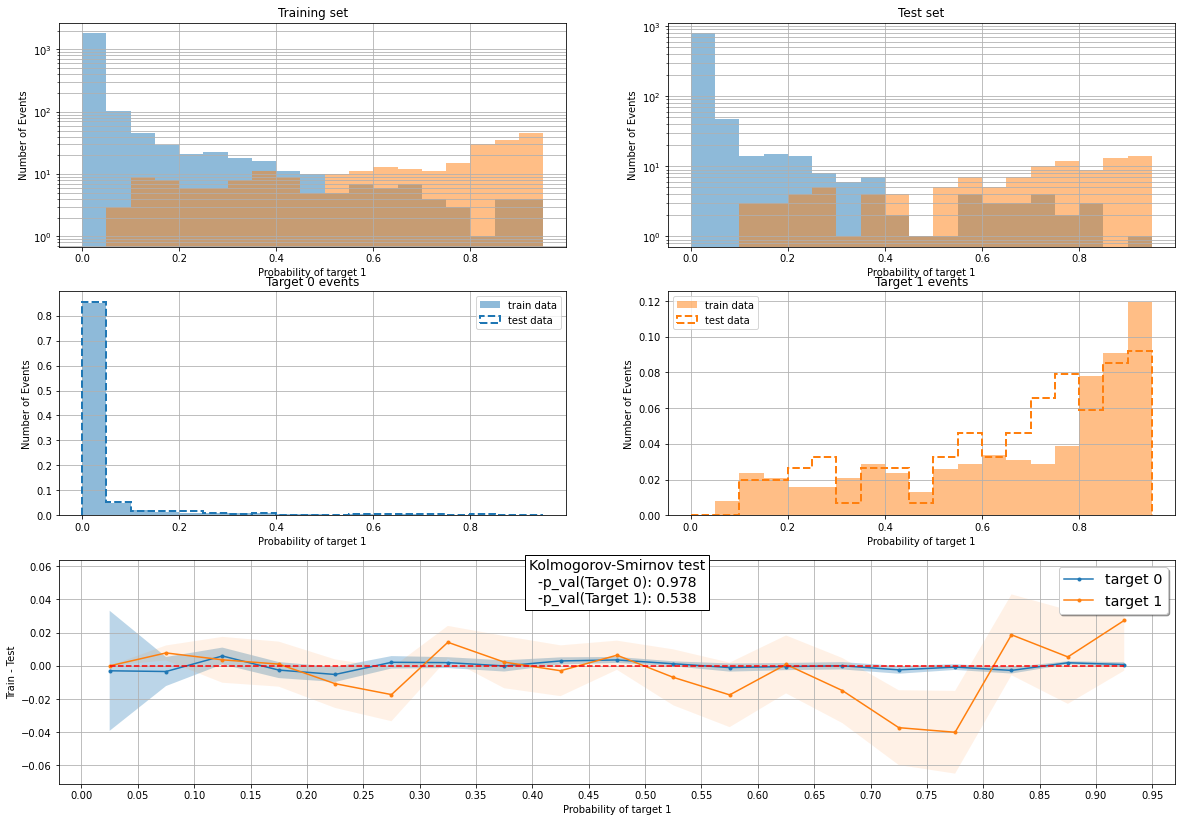

In [108]:
tr_target_0 = clf_lr.predict_proba(new_train[train['target']==0])[:,1]
tr_target_1 = clf_lr.predict_proba(new_train[train['target']==1])[:,1]

te_target_0 = clf_lr.predict_proba(new_test[test['target']==0])[:,1]
te_target_1 = clf_lr.predict_proba(new_test[test['target']==1])[:,1]


evaluate_model_stability(tr_target_0,tr_target_1, te_target_0,te_target_1)


<AxesSubplot:title={'center':'PR-Curve'}, xlabel='Recall', ylabel='Precision'>

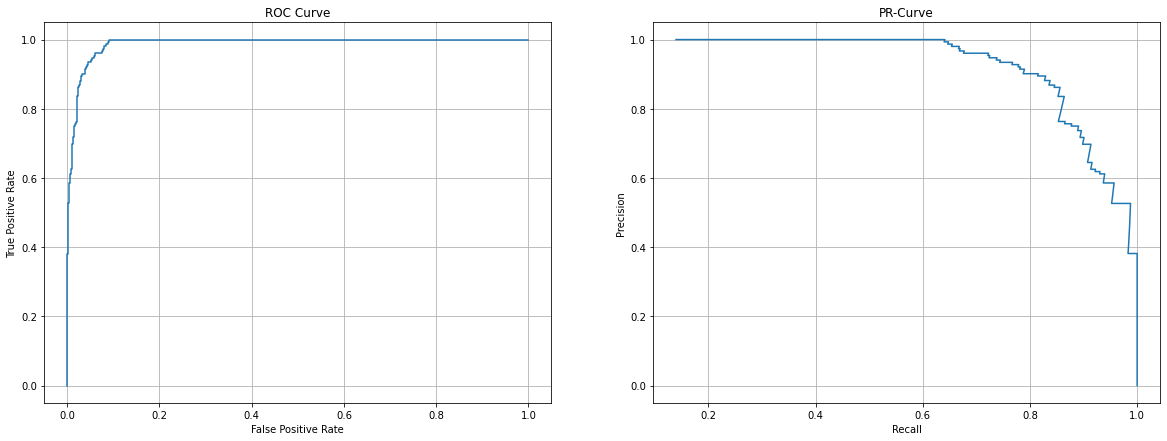

In [109]:
roc = roc_curve(test['target'],clf_lr.predict_proba(new_test)[:,1])
pr  = precision_recall_curve(test['target'],clf_lr.predict_proba(new_test)[:,1])

fig1 = plt.figure(figsize=(20,7))
plot(fig1 ,roc[0] ,roc[1] ,'False Positive Rate' , 'True Positive Rate', 'ROC Curve', 121)
plot(fig1 ,pr[0] ,pr[1] ,'Recall' , 'Precision', 'PR-Curve', 122)



## Feature ranking for classification

In [110]:
#clf_lr[:-1].get_feature_names_out()

#clf_lr.get_feature_names_out()


feature_rank=pd.DataFrame(clf_lr.named_steps['classifier'].coef_.flatten(), index=clf_lr[:-1].get_feature_names_out())#.sort_values(by,ascending=False)


In [111]:
#
#feature_rank
feature_rank.sort_values(by=feature_rank.columns[0],ascending=False, key=abs)


0
remainder__account_life_days   -4.876927
remainder__n_transactions      -2.285806
remainder__LEASING_PAYMENT     -1.628930
remainder__avg_trans_per_year   1.551931
remainder__n_salaries          -1.300290
cat__card_type_no_card         -1.124242
remainder__card_issued_days    -1.091680
remainder__max_salary           0.984211
remainder__poli_fit_params_1   -0.931355
remainder__lin_fit_params_1    -0.921653
cat__card_type_gold             0.905307
remainder__lin_fit_params_0    -0.872294
cat__card_type_classic          0.670229
remainder__poli_fit_params_3    0.474739
cat__card_type_junior          -0.449927
remainder__poli_fit_params_4   -0.363517
remainder__n_days_neg_balance  -0.339022
remainder__avg_neg_balance      0.329149
remainder__poli_fit_params_0   -0.207048
remainder__avg_salary          -0.202236
remainder__HOUSEHOLD_PAYMENT   -0.198845
remainder__poli_fit_params_5   -0.157667
remainder__INSURANCE_PAYMENT   -0.149709
remainder__account_avg_bal      0.145589
num__client_age                 0.099842
remainder__min_salary          -0.089490
remainder__UNKNOWN             -0.071583
cat__client_gender_M            0.068013
remainder__client_birth_number  0.066737
cat__client_gender_F           -0.066646
remainder__account_max_bal     -0.056090
remainder__poli_fit_params_2   -0.030503
remainder__account_min_bal     -0.027080

We can observe that the feature most correlated (anti-correlated really) with target is the 'account_life_days' and this is explained by the fact that we cut the lifetime of accounts associated to customers asking for loan to the period precedent the loan, biasing their lifetime respect to the one of the account of target 0.

The second most correlated feature is the number of transaction associated to the bank account for its entire lifetime.

As first step I will remove these 2 very biased features.

## REBALANCING THE DATASET

I am going to rebalance the dataset mixing oversampling of the minority case (target=1) and undersampling of the main category (target=0), representing the customers that did not ask for a loan.*</mark>

In [112]:
#pip install  --user imbalanced-learn

In [113]:

from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from imblearn.pipeline import Pipeline  as IPip
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# define pipeline
over = RandomOverSampler(sampling_strategy=0.2)# 
#over_2 = RandomOverSampler(sampling_strategy=0.7)#2nd strategy
under = RandomUnderSampler(sampling_strategy=1.0)
steps = [('o', over), ('u', under)]
imb_pipeline = IPip(steps=steps)

train_new_rebal, train_new_rebal['target']=imb_pipeline.fit_resample(train, train['target'])

target_1_new_percentage = train_new_rebal.target.sum() / train_new_rebal.target.count()*100
target_0_new_percentage = ( train_new_rebal.target.count() - train_new_rebal.target.sum() )/ train_new_rebal.target.count()*100

#print(target_1_new_percentage)


print('number of counts:', train_new_rebal.target.count())

if target_0_new_percentage == target_1_new_percentage :
  print("Resampling to 50-50 done!")




# evaluate pipeline
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#scores = cross_val_score(pipeline, X, y, scoring='f1_micro', cv=cv, n_jobs=-1)
#score = mean(scores)
#print('F1 Score: %.3f' % score)

number of counts: 862
Resampling to 50-50 done!


In [114]:
new_train_rebal = train_new_rebal.drop(columns='target')


#I drop the column of the feature most biased from the train set and the test set.

new_train_rebunb = new_train_rebal.drop(columns=['account_life_days','n_transactions'])


In [115]:
new_test_unb = new_test.drop(columns=['account_life_days','n_transactions'])

## Decision Tree Classifier

In [116]:
#1st model: Decision Tree

model_DT =  DecisionTreeClassifier(splitter='best', max_depth=None, min_samples_leaf=1, min_weight_fraction_leaf=0.0, 
                           max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           class_weight=None)

clf_dt = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model_DT)])


clf_dt.fit(new_train_rebal,train_new_rebal['target'])


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['client_age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['client_gender',
                                                   'card_type'])])),
                ('classifier', DecisionTreeClassifier())])

In [117]:
print("RESULT with unbiased features present")

print("Decision Tree Train Score: {0}".format(clf_dt.score(new_train_rebal,train_new_rebal['target'])))
print("Decision Tree Test Score : {0}".format(clf_dt.score(new_test,test['target'])))

RESULT with unbiased features present
Decision Tree Train Score: 1.0
Decision Tree Test Score : 0.936697247706422


In [118]:
print("RESULT without unbiased features")

clf_dt.fit(new_train_rebunb,train_new_rebal['target'])

print("Decision Tree Train Score: {0}".format(clf_dt.score(new_train_rebunb,train_new_rebal['target'])))
print("Decision Tree Test Score : {0}".format(clf_dt.score(new_test_unb,test['target'])))


RESULT without unbiased features
Decision Tree Train Score: 1.0
Decision Tree Test Score : 0.8642201834862385


In [119]:
print('Accuracy:  ', accuracy_score(test['target'],clf_dt.predict(new_test_unb)))
print('Precision: ', precision_score(test['target'],clf_dt.predict(new_test_unb)))
print('Recall:    ', recall_score(test['target'],clf_dt.predict(new_test_unb)))
print('F1:        ', f1_score(test['target'],clf_dt.predict(new_test_unb)))
print('ROC-AUC:   ', roc_auc_score(test['target'],clf_dt.predict(new_test_unb)))
print('\nConfusion Matrix\n{0}'.format(confusion_matrix(test['target'],clf_dt.predict(new_test_unb))))

Accuracy:   0.8642201834862385
Precision:  0.5081967213114754
Recall:     0.8157894736842105
F1:         0.6262626262626263
ROC-AUC:    0.843928851980698

Confusion Matrix
[[818 120]
 [ 28 124]]


## Random Forest Classifier

In [120]:
#2nd model: RANDOM FOREST
model_RF = RandomForestClassifier( criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None)

clf_rf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model_RF)])


clf_rf.fit(new_train_rebunb,train_new_rebal['target'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['client_age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['client_gender',
                                                   'card_type'])])),
                ('classifier', RandomForestClassifier())])

In [121]:
print("RESULT with biased features present")

print("Random Forest Train Score: {0}".format(clf_rf.score(new_train_rebal,train_new_rebal['target'])))
print("Random Forest Test Score : {0}".format(clf_rf.score(new_test,test['target'])))

RESULT with biased features present
Random Forest Train Score: 1.0
Random Forest Test Score : 0.8715596330275229


In [122]:
print("RESULT with biased features removed")

clf_rf.fit(new_train_rebunb,train_new_rebal['target'])

print("Random Forest Train Score: {0}".format(clf_rf.score(new_train_rebunb,train_new_rebal['target'])))
print("Random Forest Test Score : {0}".format(clf_rf.score(new_test_unb,test['target'])))

RESULT with biased features removed
Random Forest Train Score: 1.0
Random Forest Test Score : 0.8779816513761468


In [123]:
print('Accuracy:  ', accuracy_score(test['target'],clf_rf.predict(new_test_unb)))
print('Precision: ', precision_score(test['target'],clf_rf.predict(new_test_unb)))
print('Recall:    ', recall_score(test['target'],clf_rf.predict(new_test_unb)))
print('F1:        ', f1_score(test['target'],clf_rf.predict(new_test_unb)))
print('ROC-AUC:   ', roc_auc_score(test['target'],clf_rf.predict(new_test_unb)))
print('\nConfusion Matrix\n{0}'.format(confusion_matrix(test['target'],clf_rf.predict(new_test_unb))))

Accuracy:   0.8779816513761468
Precision:  0.5375494071146245
Recall:     0.8947368421052632
F1:         0.671604938271605
ROC-AUC:    0.8850016833127596

Confusion Matrix
[[821 117]
 [ 16 136]]


Model Score: 0.8385321100917431


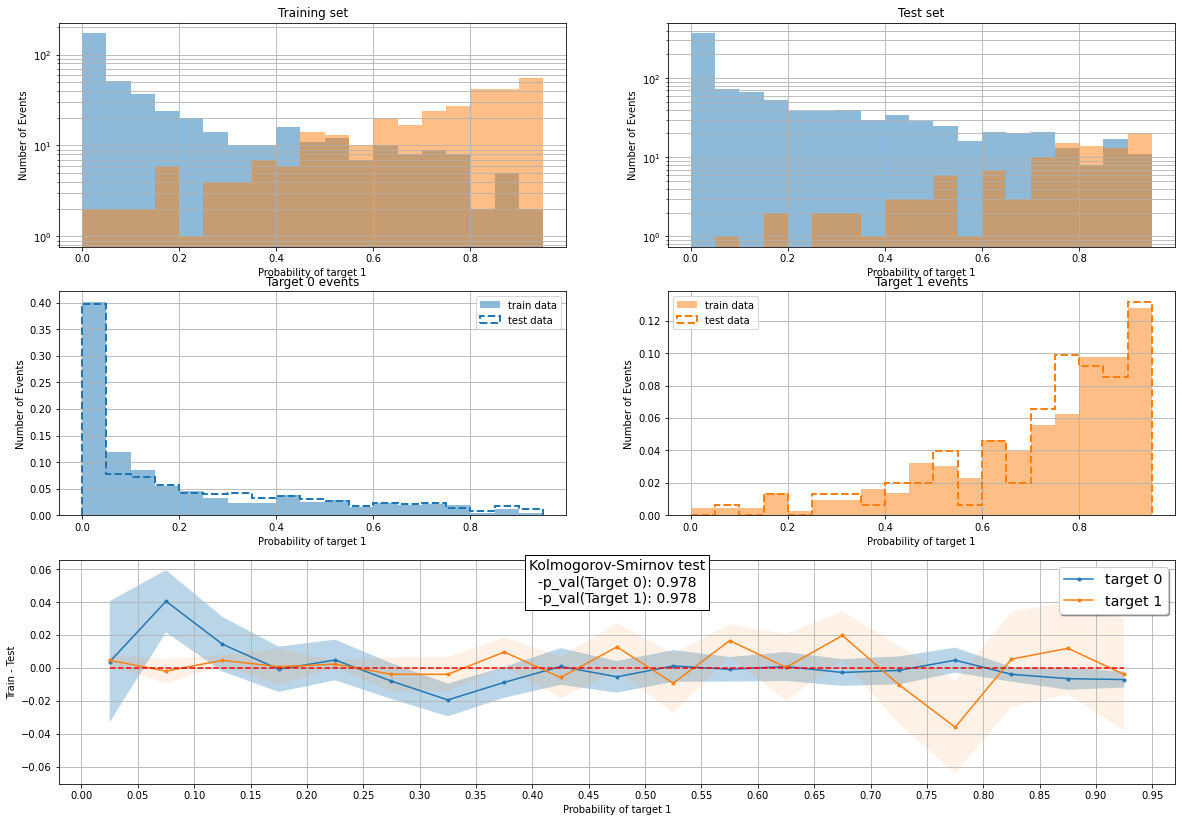

In [124]:
#Studying the impact of REBALANCING on the recovered prob. distribution of target events


clf_lr.fit(new_train_rebunb,train_new_rebal['target'])
print("Model Score: {0}".format(clf_lr.score(new_test,test['target'])))
new_tr_target_0 = clf_lr.predict_proba(new_train_rebal[train_new_rebal['target']==0])[:,1]
new_tr_target_1 = clf_lr.predict_proba(new_train_rebal[train_new_rebal['target']==1])[:,1]

new_te_target_0 = clf_lr.predict_proba(new_test[test['target']==0])[:,1]
new_te_target_1 = clf_lr.predict_proba(new_test[test['target']==1])[:,1]


evaluate_model_stability(new_tr_target_0,new_tr_target_1, new_te_target_0,new_te_target_1)

Fitting the classifier model on the rebalanced dataset improved the recovered probability distribution for the target class, increasing also the p-value for the KS test on target 1.

<AxesSubplot:title={'center':'PR-Curve'}, xlabel='Recall', ylabel='Precision'>

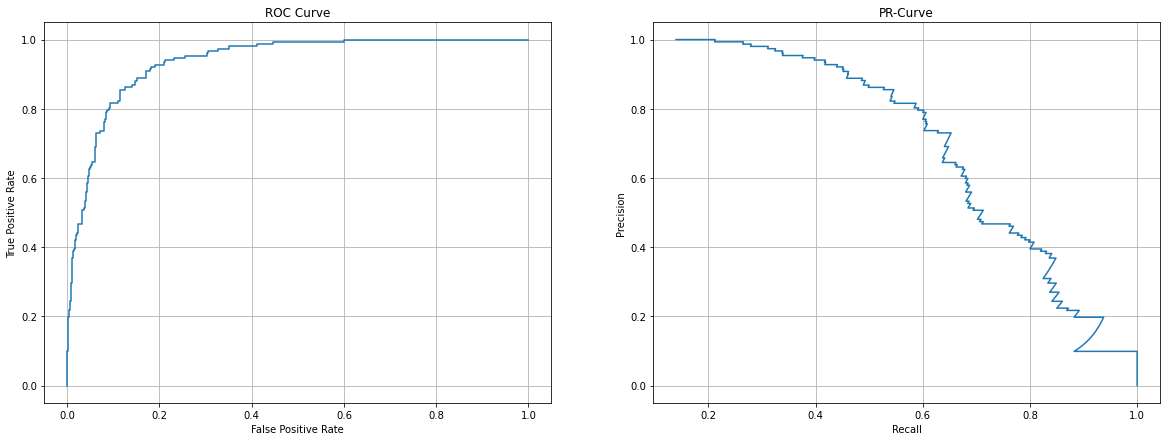

In [125]:
roc = roc_curve(test['target'],clf_lr.predict_proba(new_test)[:,1])
pr  = precision_recall_curve(test['target'],clf_lr.predict_proba(new_test)[:,1])

fig1 = plt.figure(figsize=(20,7))
plot(fig1 ,roc[0] ,roc[1] ,'False Positive Rate' , 'True Positive Rate', 'ROC Curve', 121)
plot(fig1 ,pr[0] ,pr[1] ,'Recall' , 'Precision', 'PR-Curve', 122)

Both the Decision Tree and the Random Forest models are overfitting the training set, as we can observe comparing the accuracy training score and the accuracy score on the test dataset. This is caused by the bias introduced with the oversampling of the minority class performed during the rebalancing of the training set. We need to change the strategy for rebalancing  and after that we can move to retuning the model hyper-parameters.

In what follows I will adopt the baggingclassifier approach to solve the unbalance problem, and I will operate this method on the preprocessed trainig set where I removed the feture more correlated with target ('account_life_days').


In [126]:
# Defining 2nd strategy for rebalancing
over = RandomOverSampler(sampling_strategy=0.2)# 
over_2 = RandomOverSampler(sampling_strategy=0.7)#2nd strategy
under = RandomUnderSampler(sampling_strategy=1.0)
steps = [('o', over_2), ('u', under)]
imb_pipeline = IPip(steps=steps)

train_new_rebal, train_new_rebal['target']=imb_pipeline.fit_resample(train, train['target'])

target_1_new_percentage = train_new_rebal.target.sum() / train_new_rebal.target.count()*100
target_0_new_percentage = ( train_new_rebal.target.count() - train_new_rebal.target.sum() )/ train_new_rebal.target.count()*100

#print(target_1_new_percentage)


print('number of counts:', train_new_rebal.target.count())

if target_0_new_percentage == target_1_new_percentage :
  print("Resampling to 50-50 done!")




number of counts: 3018
Resampling to 50-50 done!


In [127]:
new_train_rebal = train_new_rebal.drop(columns='target')


#I drop the column of the feature most biased from the train set and the test set.

new_train_rebunb = new_train_rebal.drop(columns=['account_life_days','n_transactions'])

new_test_unb = new_test.drop(columns=['account_life_days','n_transactions'])


In [128]:
#fitting decisition tree after REBALANCING 2

clf_dt.fit(new_train_rebunb, train_new_rebal['target'])

print("RESULT with unbiased features present")

print("Decision Tree Train Score: {0}".format(clf_dt.score(new_train_rebunb,train_new_rebal['target'])))
print("Decision Tree Test Score : {0}".format(clf_dt.score(new_test_unb,test['target'])))

RESULT with unbiased features present
Decision Tree Train Score: 1.0
Decision Tree Test Score : 0.8798165137614679


In [129]:
print('Accuracy:  ', accuracy_score(test['target'],clf_dt.predict(new_test_unb)))
print('Precision: ', precision_score(test['target'],clf_dt.predict(new_test_unb)))
print('Recall:    ', recall_score(test['target'],clf_dt.predict(new_test_unb)))
print('F1:        ', f1_score(test['target'],clf_dt.predict(new_test_unb)))
print('ROC-AUC:   ', roc_auc_score(test['target'],clf_dt.predict(new_test_unb)))
print('\nConfusion Matrix\n{0}'.format(confusion_matrix(test['target'],clf_dt.predict(new_test_unb))))

Accuracy:   0.8798165137614679
Precision:  0.5636363636363636
Recall:     0.6118421052631579
F1:         0.586750788643533
ROC-AUC:    0.7675415217147346

Confusion Matrix
[[866  72]
 [ 59  93]]


In [130]:
#fitting random forest after REBALANCING 2
print("RESULT with biased features removed")

clf_rf.fit(new_train_rebunb,train_new_rebal['target'])

print("Random Forest Train Score: {0}".format(clf_rf.score(new_train_rebunb,train_new_rebal['target'])))
print("Random Forest Test Score : {0}".format(clf_rf.score(new_test_unb,test['target'])))

RESULT with biased features removed
Random Forest Train Score: 1.0
Random Forest Test Score : 0.926605504587156


In [131]:
y_pred_rf=clf_rf.predict(new_test_unb)

print('Accuracy:  ', accuracy_score(test['target'],y_pred_rf))
print('Precision: ', precision_score(test['target'],y_pred_rf))
print('Recall:    ', recall_score(test['target'], y_pred_rf)) #clf_rf.predict(new_test_unb)))
print('F1:        ', f1_score(test['target'], y_pred_rf)) #clf_rf.predict(new_test_unb)))
print('ROC-AUC:   ', roc_auc_score(test['target'], y_pred_rf)) #clf_rf.predict(new_test_unb)))
print('\nConfusion Matrix\n{0}'.format(confusion_matrix(test['target'], y_pred_rf)))

Accuracy:   0.926605504587156
Precision:  0.7278481012658228
Recall:     0.756578947368421
F1:         0.7419354838709676
ROC-AUC:    0.8553683649422062

Confusion Matrix
[[895  43]
 [ 37 115]]


In [132]:
from sklearn.metrics import balanced_accuracy_score

print('Accuracy:  ', accuracy_score(test['target'],y_pred_rf))
print( f"Balanced accuracy: {balanced_accuracy_score(test['target'],y_pred_rf):.2f}")

Accuracy:   0.926605504587156
Balanced accuracy: 0.86


In [133]:
new_train_unb = new_train.drop(columns=['account_life_days','n_transactions'])

We can observe that the 2nd rebalancing strategy limits the overfitting problem. 
We could also not rebalance the training set 'manually' but training the classifier adopting a cost-sensitive approach, as illustrated below.

In [134]:
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import BalancedBaggingClassifier

b_rf= BalancedRandomForestClassifier(bootstrap=True, class_weight='balanced',
                                                criterion='gini', max_depth=40,
                                                max_features=2,
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=310, n_jobs=-1,
                                                oob_score=False, random_state=0,
                                                replacement=True,
                                                sampling_strategy='auto',
                                                verbose=0, warm_start=False)

clf_brf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model_RF)])

clf_brf.fit(new_train_unb,train['target'])

y_pred_brf= clf_brf.predict(new_test_unb)


print("Balanced Random Forest classifier performances:")


y_pred_rf=clf_brf.predict(new_test_unb)

print('Accuracy:  ', accuracy_score(test['target'],y_pred_rf))
print('Precision: ', precision_score(test['target'],y_pred_rf))
print('Recall:    ', recall_score(test['target'], y_pred_rf)) #clf_rf.predict(new_test_unb)))
print('F1:        ', f1_score(test['target'], y_pred_rf)) #clf_rf.predict(new_test_unb)))
print('ROC-AUC:   ', roc_auc_score(test['target'], y_pred_rf)) #clf_rf.predict(new_test_unb)))
print('\nConfusion Matrix\n{0}'.format(confusion_matrix(test['target'], y_pred_rf)))

print( f"Balanced accuracy: {balanced_accuracy_score(test['target'],y_pred_brf):.2f}")
#print(f"Geometric mean {geometric_mean_score(y_test, y_pred_rf):.2f}")



Balanced Random Forest classifier performances:
Accuracy:   0.9311926605504587
Precision:  0.8737864077669902
Recall:     0.5921052631578947
F1:         0.7058823529411763
ROC-AUC:    0.7891229940522949

Confusion Matrix
[[925  13]
 [ 62  90]]
Balanced accuracy: 0.79


In [135]:
print("Balanced Random Forest Train Score: {0}".format(clf_brf.score(new_train_unb,train['target'])))
print("Balanced Random Forest Test Score : {0}".format(clf_brf.score(new_test_unb,test['target'])))


#BalancedBaggingClassifier(base_estimator=HistGradientBoostingClassifier(random_state=42),n_estimators=10,random_state=42,n_jobs=-1, )

Balanced Random Forest Train Score: 1.0
Balanced Random Forest Test Score : 0.9311926605504587


The more performing classifier is the one based on the Random Forest estimator, and we can observe that our 2nd strategy for the rebalancing obtain results similar to the 'BalancedRandomForest' classifier trained on the unbiased training dataset, in terms of accuracy and F1, ROC scores.

We can move then to tuning the hyperparameters of the model using cross-validation.

### Tuning of the model hyperparameters

In [136]:



param_grid = {
        'classifier__max_depth':range(2,10),
        'classifier__min_samples_split': [5,10,15,20]}
        #'classifier__criterion':["gini", "entropy"]}
    

n_folds = 20

gs_dt = GridSearchCV(clf_dt, param_grid, 
                  scoring={'roc':'roc_auc','f1':'f1'},
                  n_jobs= -1, cv=n_folds, 
                  refit='roc', verbose=0, pre_dispatch='2*n_jobs',
                  return_train_score=True)
n_fits = 1
for item in param_grid: 
    n_fits*=len(param_grid[item])
    

    
print('You are about to run {0} fits'.format(n_fits*n_folds))




You are about to run 640 fits


In [137]:
%%time

_ = gs_dt.fit(new_train_rebunb,train_new_rebal['target'])
results = pd.DataFrame(data = gs_dt.cv_results_)
results.sort_values(by=['mean_test_roc'], ascending =False).head(5)

CPU times: user 3.47 s, sys: 1.71 s, total: 5.18 s
Wall time: 17 s


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
30       0.067746      0.004298         0.023245        0.001545   
31       0.069087      0.010938         0.023892        0.003775   
24       0.081610      0.014125         0.029599        0.009730   
27       0.092308      0.025977         0.032039        0.007843   
26       0.089449      0.022490         0.036977        0.012621   

   param_classifier__max_depth param_classifier__min_samples_split  \
30                           9                                  15   
31                           9                                  20   
24                           8                                   5   
27                           8                                  20   
26                           8                                  15   

                                               params  split0_test_roc  \
30  {'classifier__max_depth': 9, 'classifier__min_...         0.949298   
31  {'classifier__max_depth': 9, 'classifier__min_...         0.947895   
24  {'classifier__max_depth': 8, 'classifier__min_...         0.954123   
27  {'classifier__max_depth': 8, 'classifier__min_...         0.945614   
26  {'classifier__max_depth': 8, 'classifier__min_...         0.946930   

    split1_test_roc  split2_test_roc  split3_test_roc  split4_test_roc  \
30         0.971579         0.957456         0.986842         0.949035   
31         0.969123         0.952456         0.985351         0.932456   
24         0.970175         0.965175         0.982544         0.948860   
27         0.975789         0.960877         0.979474         0.940614   
26         0.978158         0.963246         0.981491         0.927456   

    split5_test_roc  split6_test_roc  split7_test_roc  split8_test_roc  \
30         0.968596         0.960175         0.957105         0.954123   
31         0.966228         0.970526         0.955088         0.951667   
24         0.959474         0.961316         0.967719         0.956316   
27         0.954474         0.967105         0.964211         0.953860   
26         0.957193         0.960351         0.961579         0.955965   

    split9_test_roc  split10_test_roc  split11_test_roc  split12_test_roc  \
30         0.970000          0.960439          0.953246          0.955702   
31         0.967368          0.953246          0.949474          0.954035   
24         0.968070          0.955877          0.950877          0.955351   
27         0.957719          0.951491          0.940614          0.955439   
26         0.960877          0.945351          0.942193          0.940965   

    split13_test_roc  split14_test_roc  split15_test_roc  split16_test_roc  \
30          0.943860          0.947193          0.956316          0.950702   
31          0.940351          0.945088          0.954737          0.950702   
24          0.929386          0.922368          0.946228          0.949561   
27          0.936579          0.938158          0.947105          0.947281   
26          0.927281          0.936754          0.958158          0.947281   

    split17_test_roc  split18_test_roc  split19_test_roc  mean_test_roc  \
30          0.967807          0.957778          0.963022       0.959014   
31          0.971579          0.955289          0.959111       0.956588   
24          0.966667          0.953689          0.943022       0.955340   
27          0.959912          0.959200          0.958133       0.954682   
26          0.963333          0.961689          0.962400       0.953933   

    std_test_roc  rank_test_roc  split0_train_roc  split1_train_roc  \
30      0.009892              1          0.974239          0.972333   
31      0.011884              2          0.972878          0.970923   
24      0.013508              3          0.971035          0.969023   
27      0.011435              4          0.967512          0.965086   
26      0.014165              5          0.969213          0.966829   

    split2_train_roc  split3_

In [138]:
print("Decision Tree Train Score Post re-fit: {0}".format(gs_dt.score(new_train_rebunb,
                                                              train_new_rebal['target'])))
print("Decision Tree  Test Score Post re-fit: {0}".format(gs_dt.score(new_test,
                                                             test['target'])))

Decision Tree Train Score Post re-fit: 0.9731814546781603
Decision Tree  Test Score Post re-fit: 0.8793029682414992


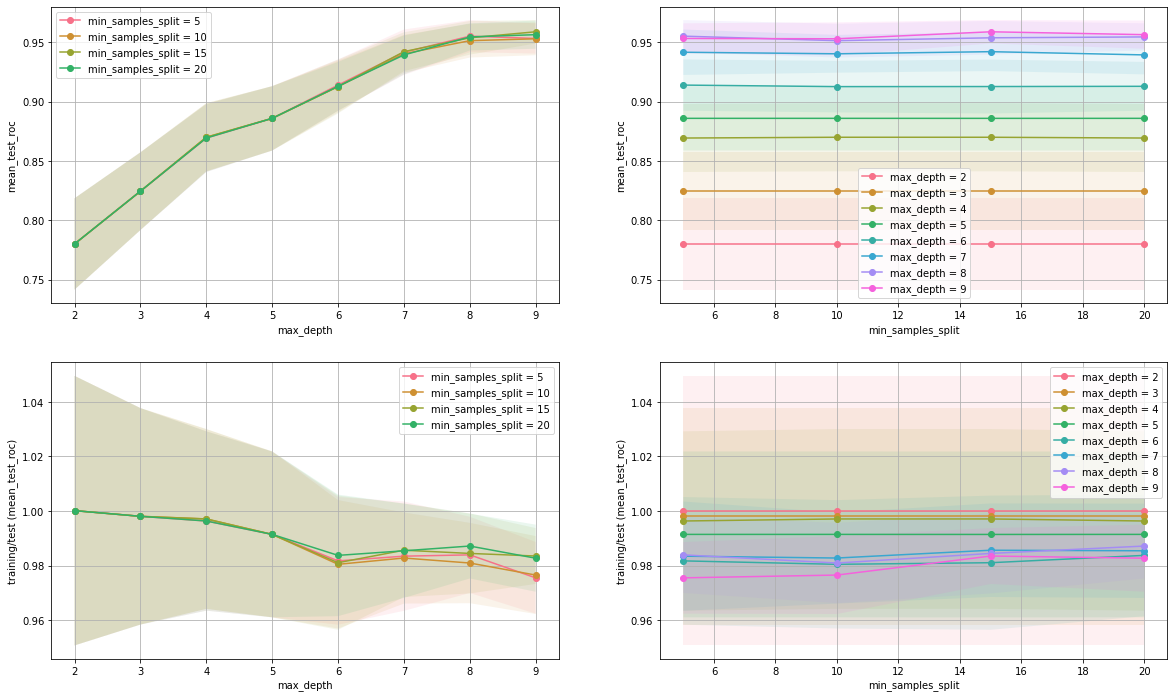

In [139]:

#I am going to select the two params that I want to visualize
filtered_param_grid = param_grid.copy()
#filtered_param_grid.pop('classifier__criterion')
    
#I fix one value for each param that I don't want to visualize
#filtered_results = results[results.param_classifier__criterion == 'gini']

plot_gs_results(filtered_param_grid,
                results,
                    'param_classifier__min_samples_split',
                    'param_classifier__max_depth',
                    'roc')

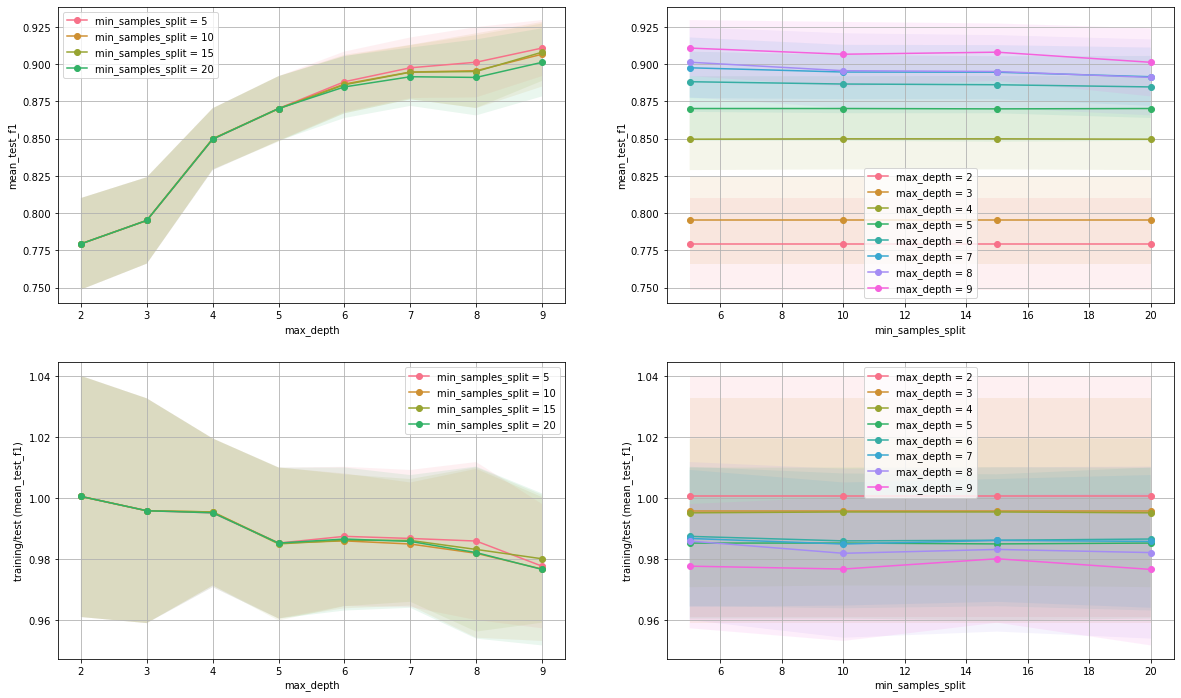

In [140]:
#PLOTS for F1 score

plot_gs_results(filtered_param_grid,
                results,
                    'param_classifier__min_samples_split',
                    'param_classifier__max_depth',
                    'f1')

Looking at the plots above we can observe that we get the greater F1 and ROC score on the test set, associated to the Decision tree classifier, if we choose max_depth=9, but in this case we have also a greater difference between the training score and test score. If we want to minimize the difference between the training score and the test score while maximizing the test score, the best choice for the Decisiton Tree Classifier is 'max_depth= 5', almost independently from the min_samples_split.

In [141]:
gs_rf = GridSearchCV(clf_rf, param_grid, 
                  scoring={'roc':'roc_auc','f1':'f1'},
                  n_jobs= -1, cv=n_folds, 
                  refit='roc', verbose=0, pre_dispatch='2*n_jobs',
                  return_train_score=True)
    
print('You are about to run {0} fits'.format(n_fits*n_folds))



You are about to run 640 fits


In [142]:
%%time

_ = gs_rf.fit(new_train_rebunb,train_new_rebal['target'])
results_rf = pd.DataFrame(data = gs_rf.cv_results_)
results_rf.sort_values(by=['mean_test_roc'], ascending =False).head(5)


CPU times: user 4.01 s, sys: 259 ms, total: 4.27 s
Wall time: 1min 32s


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
28       1.066215      0.348706         0.062342        0.005653   
29       1.042527      0.317356         0.074107        0.036794   
30       0.880731      0.172356         0.078824        0.038924   
31       1.258476      0.319376         0.079964        0.049688   
24       0.891128      0.200078         0.066484        0.016095   

   param_classifier__max_depth param_classifier__min_samples_split  \
28                           9                                   5   
29                           9                                  10   
30                           9                                  15   
31                           9                                  20   
24                           8                                   5   

                                               params  split0_test_roc  \
28  {'classifier__max_depth': 9, 'classifier__min_...         0.981930   
29  {'classifier__max_depth': 9, 'classifier__min_...         0.975439   
30  {'classifier__max_depth': 9, 'classifier__min_...         0.978070   
31  {'classifier__max_depth': 9, 'classifier__min_...         0.973509   
24  {'classifier__max_depth': 8, 'classifier__min_...         0.975263   

    split1_test_roc  split2_test_roc  split3_test_roc  split4_test_roc  \
28         0.990877         0.990175         0.993158         0.984561   
29         0.987018         0.986491         0.991404         0.986140   
30         0.987544         0.985614         0.990175         0.979825   
31         0.987368         0.986491         0.986667         0.977193   
24         0.983684         0.986491         0.991053         0.979474   

    split5_test_roc  split6_test_roc  split7_test_roc  split8_test_roc  \
28         0.987895         0.994737         0.990877         0.988246   
29         0.988246         0.994211         0.986842         0.987719   
30         0.985789         0.993860         0.986667         0.985614   
31         0.985789         0.993333         0.986140         0.988772   
24         0.986316         0.994035         0.985965         0.988246   

    split9_test_roc  split10_test_roc  split11_test_roc  split12_test_roc  \
28         0.993509          0.996667          0.989123          0.998070   
29         0.989298          0.999123          0.981930          0.997193   
30         0.988772          0.996316          0.981053          0.994386   
31         0.988246          0.996316          0.979474          0.993860   
24         0.987018          0.994737          0.978947          0.994211   

    split13_test_roc  split14_test_roc  split15_test_roc  split16_test_roc  \
28          0.988246          0.973333          0.988772          0.981930   
29          0.988421          0.973509          0.989825          0.981228   
30          0.986842          0.974561          0.987018          0.978772   
31          0.989825          0.969123          0.985263          0.980000   
24          0.985088          0.966667          0.990000          0.978246   

    split17_test_roc  split18_test_roc  split19_test_roc  mean_test_roc  \
28          0.983509          0.994133          0.985067       0.988741   
29          0.979825          0.992000          0.982400       0.986913   
30          0.978421          0.990578          0.983644       0.985676   
31          0.977193          0.987022          0.983644       0.984761   
24          0.977719          0.989511          0.981867       0.984727   

    std_test_roc  rank_test_roc  split0_train_roc  split1_train_roc  \
28      0.005737              1          0.995877          0.995523   
29      0.006375              2          0.994237          0.995343   
30      0.005740              3          0.994275          0.993622   
31      0.006719              4          0.993904          0.992612   
24      0.006963              5          0.992540          0.992235   

    split2_train_roc  split3_

In [143]:
print("RF Train Score Post re-fit: {0}".format(gs_rf.score(new_train_rebunb,
                                                              train_new_rebal['target'])))
print("RF Test Score Post re-fit: {0}".format(gs_rf.score(new_test, test['target'])))

RF Train Score Post re-fit: 0.9955539570177784
RF Test Score Post re-fit: 0.9522921108742005


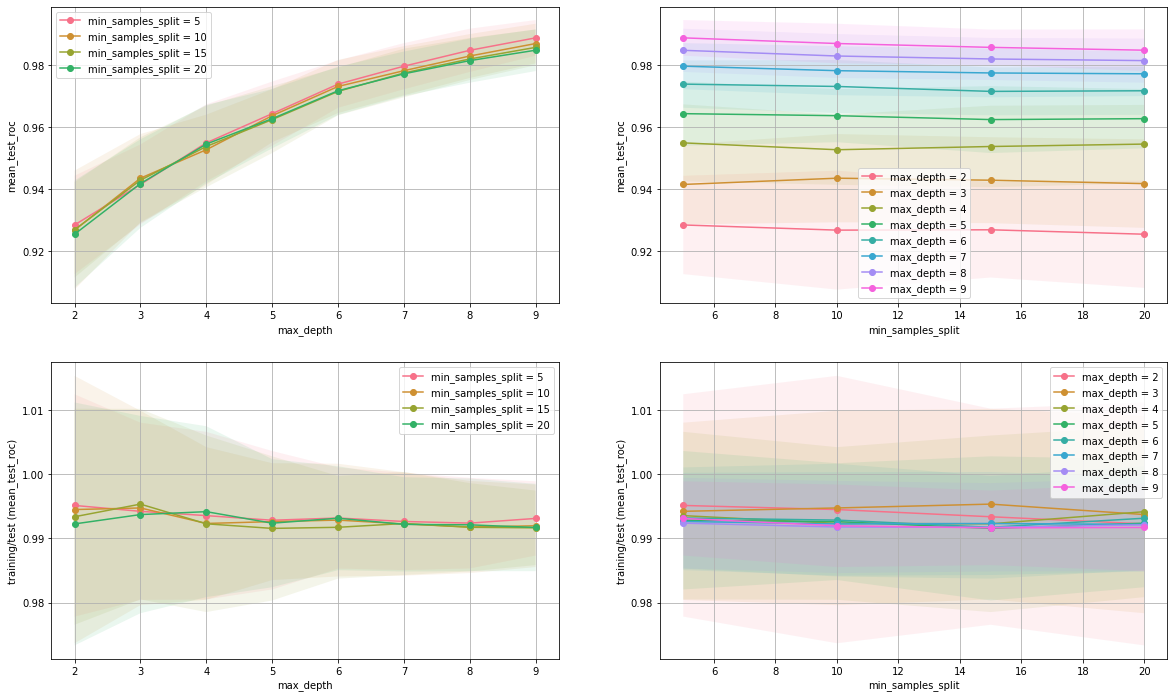

In [144]:

    
#I fix one value for each param that I don't want to visualize
#filtered_results = results[results.param_classifier__criterion == 'gini']

plot_gs_results(filtered_param_grid,
                results_rf,
                    'param_classifier__min_samples_split',
                    'param_classifier__max_depth',
                    'roc')

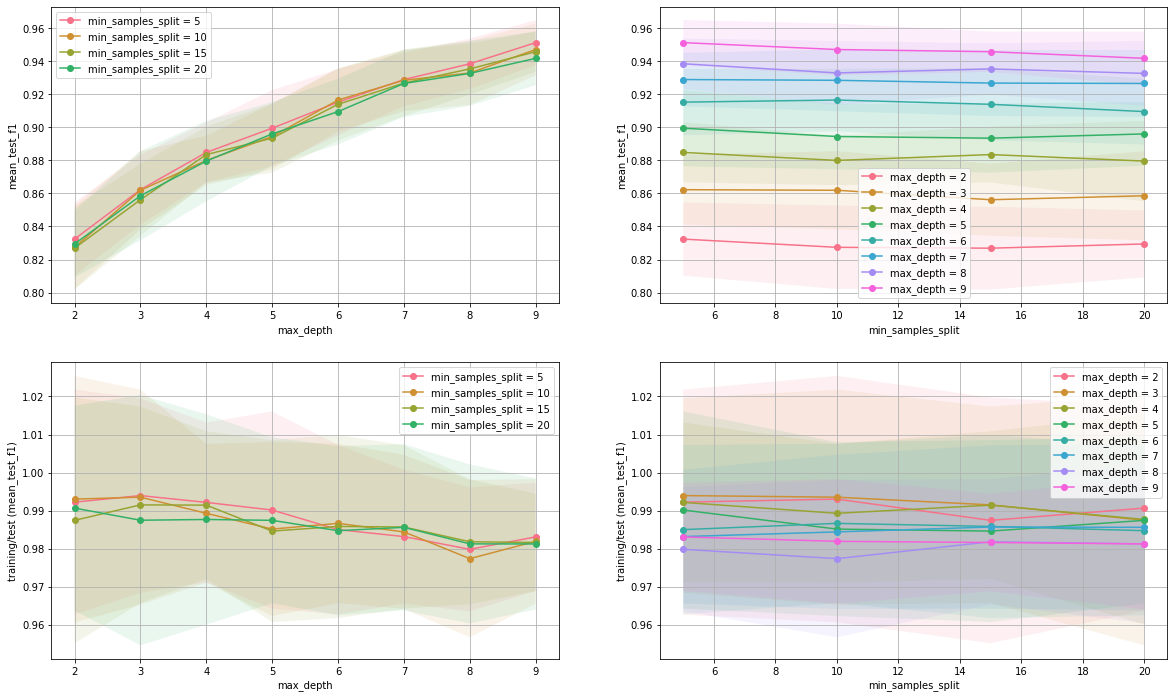

In [145]:
plot_gs_results(filtered_param_grid,
                results_rf,
                    'param_classifier__min_samples_split',
                    'param_classifier__max_depth',
                    'f1')

Looking at the plots above it's easily to observe that  for the Random forest classifier we get a better ROC-AUC/F1 score with max_depth=9, but in this  case we have more discrepancy between training score and test score.

If we want to minimize the difference between the training score and the test score while maximizing the test score, the best choice for the Random Forest Classifier is 'max_depth= 4', with min_samples_split=15.

The more performing model remains the Random Forest classifier, also after the retuning, and we can investigate the 
behaviour of this model if we substitute the 'entropy' to 'gini' as param_classifier__criterion.


In [146]:


#2nd model: RANDOM FOREST
model_RF = RandomForestClassifier( criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None)

clf_rf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model_RF)])

param_grid = {
        'classifier__max_depth':range(2,10),
        'classifier__min_samples_split': [5,10,15,20]}
        #'classifier__criterion':["gini", "entropy"]}
    

n_folds = 20

gs_rf = GridSearchCV(clf_rf, param_grid, 
                  scoring={'roc':'roc_auc','f1':'f1'},
                  n_jobs= -1, cv=n_folds, 
                  refit='roc', verbose=0, pre_dispatch='2*n_jobs',
                  return_train_score=True)
n_fits = 1
for item in param_grid: 
    n_fits*=len(param_grid[item])
    

    
print('You are about to run {0} fits'.format(n_fits*n_folds))




You are about to run 640 fits


In [147]:
%%time

_ = gs_rf.fit(new_train_rebunb,train_new_rebal['target'])
results_rf2 = pd.DataFrame(data = gs_rf.cv_results_)
results_rf2.sort_values(by=['mean_test_roc'], ascending =False).head(5)


CPU times: user 4.03 s, sys: 236 ms, total: 4.27 s
Wall time: 1min 51s


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
28       1.507319      0.342545         0.086394        0.056179   
29       1.680281      0.499493         0.113141        0.099582   
30       1.152073      0.055818         0.058002        0.002671   
31       1.365289      0.386131         0.052662        0.010256   
24       1.384906      0.370303         0.059097        0.005044   

   param_classifier__max_depth param_classifier__min_samples_split  \
28                           9                                   5   
29                           9                                  10   
30                           9                                  15   
31                           9                                  20   
24                           8                                   5   

                                               params  split0_test_roc  \
28  {'classifier__max_depth': 9, 'classifier__min_...         0.975789   
29  {'classifier__max_depth': 9, 'classifier__min_...         0.974737   
30  {'classifier__max_depth': 9, 'classifier__min_...         0.975614   
31  {'classifier__max_depth': 9, 'classifier__min_...         0.970877   
24  {'classifier__max_depth': 8, 'classifier__min_...         0.974912   

    split1_test_roc  split2_test_roc  split3_test_roc  split4_test_roc  \
28         0.987018         0.989474         0.992105         0.983333   
29         0.987544         0.985789         0.990877         0.981228   
30         0.987018         0.985614         0.990702         0.977895   
31         0.987368         0.986140         0.990351         0.978596   
24         0.985965         0.985088         0.989123         0.977544   

    split5_test_roc  split6_test_roc  split7_test_roc  split8_test_roc  \
28         0.988246         0.994211         0.987193         0.988772   
29         0.988596         0.992807         0.986842         0.984737   
30         0.986842         0.994035         0.985263         0.987018   
31         0.985614         0.992632         0.985263         0.983860   
24         0.985088         0.991228         0.985263         0.981404   

    split9_test_roc  split10_test_roc  split11_test_roc  split12_test_roc  \
28         0.991053          0.998246          0.983158          0.996667   
29         0.990351          0.995965          0.982281          0.993684   
30         0.985263          0.996491          0.980702          0.993684   
31         0.986842          0.995965          0.982281          0.993333   
24         0.986491          0.994211          0.974912          0.995088   

    split13_test_roc  split14_test_roc  split15_test_roc  split16_test_roc  \
28          0.988421          0.971579          0.990526          0.981579   
29          0.987193          0.969123          0.989123          0.979298   
30          0.984561          0.967895          0.987719          0.978421   
31          0.986316          0.968070          0.984386          0.980175   
24          0.983860          0.967193          0.986491          0.978421   

    split17_test_roc  split18_test_roc  split19_test_roc  mean_test_roc  \
28          0.980526          0.992000          0.983822       0.987186   
29          0.978596          0.991822          0.985244       0.985792   
30          0.976140          0.985422          0.981333       0.984382   
31          0.978421          0.986133          0.976000       0.983931   
24          0.972281          0.985067          0.978133       0.982888   

    std_test_roc  rank_test_roc  split0_train_roc  split1_train_roc  \
28      0.006469              1          0.994633          0.994268   
29      0.006526              2          0.994677          0.994285   
30      0.006777              3          0.993819          0.993434   
31      0.006896              4          0.992448          0.993061   
24      0.007076              5          0.991873          0.991553   

    split2_train_roc  split3_

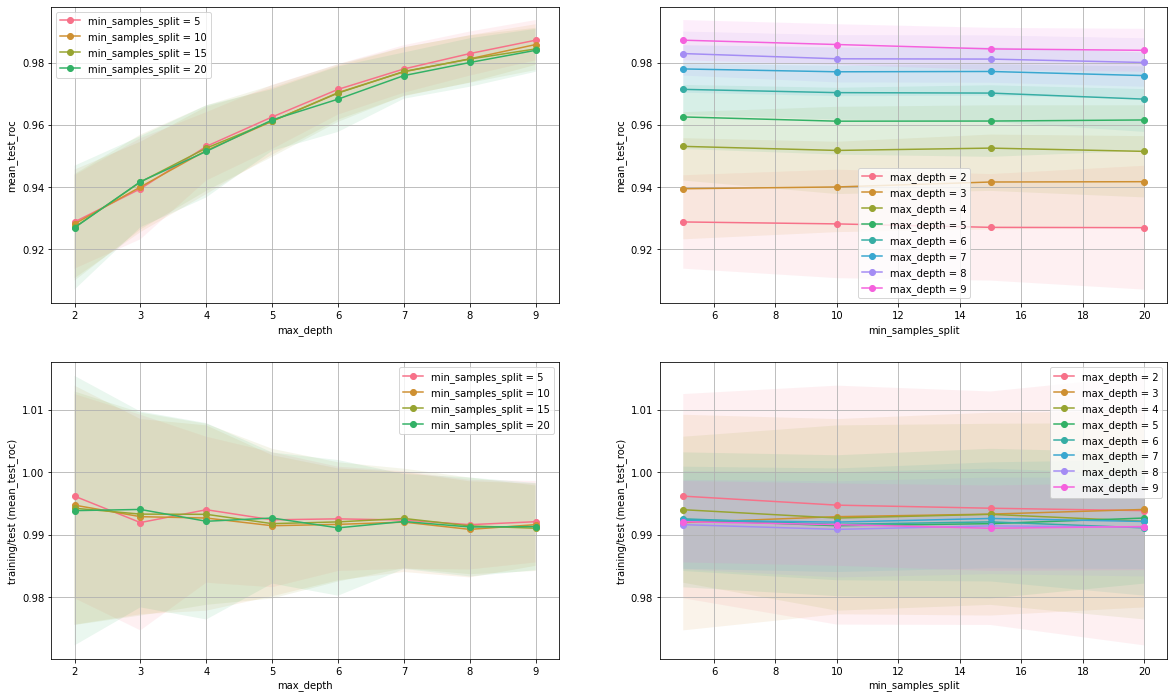

In [148]:
plot_gs_results(param_grid,results_rf2,'param_classifier__min_samples_split', 'param_classifier__max_depth', 'roc')

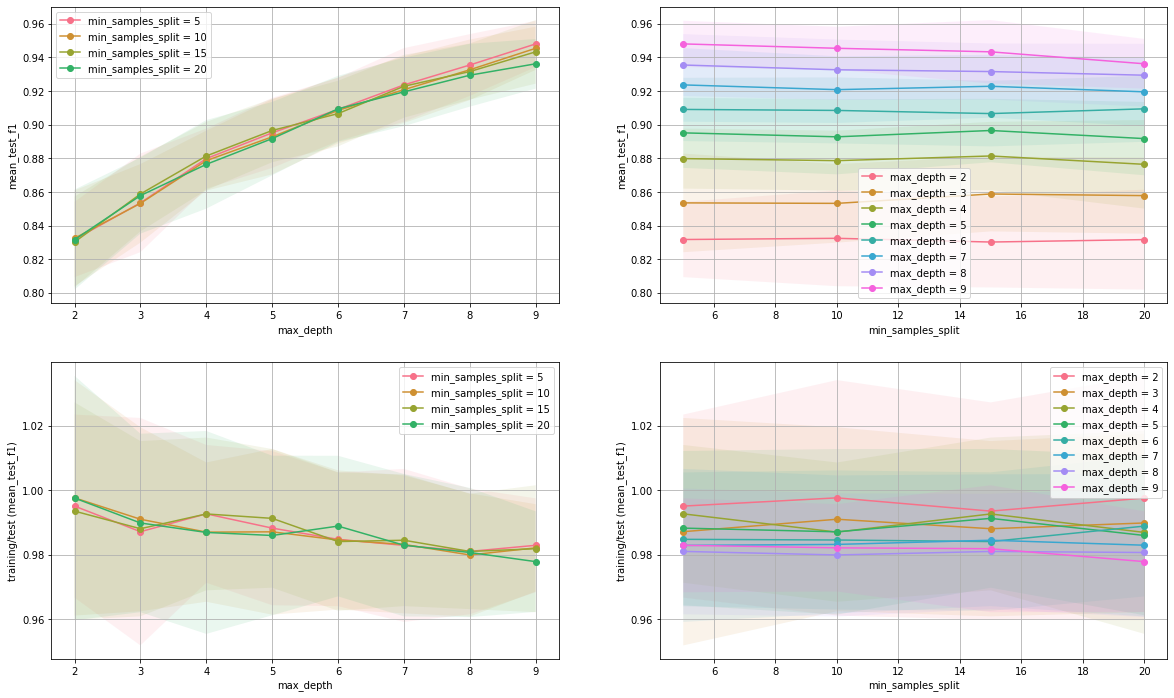

In [149]:
plot_gs_results(filtered_param_grid,
                results_rf2,
                    'param_classifier__min_samples_split',
                    'param_classifier__max_depth',
                    'f1')

In [150]:
print("RF Train Score Post re-fit: {0}".format(gs_rf.score(new_train_rebunb,
                                                              train_new_rebal['target'])))
print("RF Test Score Post re-fit: {0}".format(gs_rf.score(new_test, test['target'])))

RF Train Score Post re-fit: 0.994400287034146
RF Test Score Post re-fit: 0.9518502412748288


We can observe that the test accuracy score is almost unchanged, and the best param choice is 'max_depth=4'

**Histogram of feature importance for Random Forest Classifier**

In [169]:
clf_rf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model_RF)])

clf_rf.fit(new_train_rebunb,train_new_rebal['target'])




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['client_age']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['client_gender',
                                                   'card_type'])])),
                ('classifier', RandomForestClassifier(criterion='entropy'))])

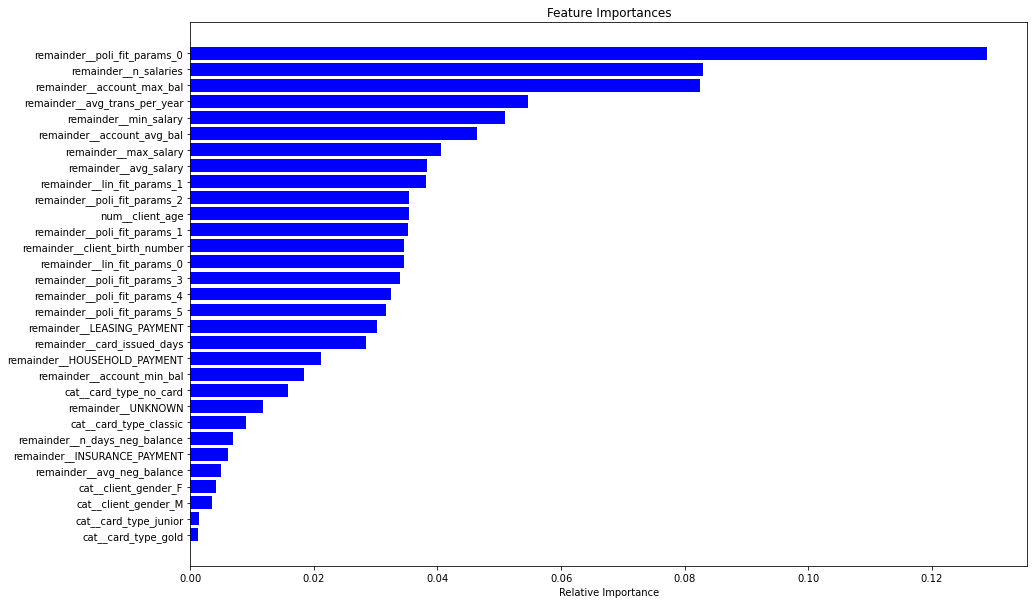

In [170]:
# get the features names array that passed on feature selection object
x_features = clf_rf.steps[0][1].get_feature_names_out()



# take the array with feature importance values
importances = clf_rf.steps[1][1].feature_importances_ 

# sort the numbers
indices = np.argsort(importances) 

#plot results
plt.figure(figsize=(15,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [x_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
